In [1]:
%tensorflow_version 1.x
import tensorflow
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

seed = 42
np.random.seed(seed)
% matplotlib inline

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
IMAGE_DIRECTORY = '/content/drive/My Drive/Springboard DS Course/CAPSTONE 2/IMAGES/NEW_FINAL_PICS'
REPOSITORY = '/content/drive/My Drive/Springboard DS Course/REPOSITORY/springboard'
os.chdir(REPOSITORY+'/faces_capstone2')

In [4]:
from keras.models import Sequential

class Decoder(Sequential):
  def load_data(self, cat_dir, face_dir, n_images):
    self.imgs = []
    cat_samples = np.random.choice(cat_dir, int(n_images/2), replace=False)
    face_samples = np.random.choice(face_dir, int(n_images/2), replace=False)
    all_samples = np.concatenate((cat_samples, face_samples))
    try:
      for file in tqdm(all_samples):
        fn = IMAGE_DIRECTORY + '/' + file
        img = cv2.imread(fn)
        rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.imgs.append(rgb_image.astype(np.float32) / 255.)
    except:
      print(file)
    np.random.shuffle(self.imgs)
    x_all = np.arange(len(self.imgs))
    self.all_dim = np.asarray(self.imgs).shape[0]
    X = np.array(x_all)
    y = np.array(self.imgs)
    self.X = X
    self.y = y
    return X, y
  def build_model(self, n_components, model_filename, log_filename, n_dim, decoder=None):
    os.chdir(REPOSITORY+'/faces_capstone2')
    decoder = Sequential()
    decoder.add(Embedding(input_dim=n_dim, output_dim=n_components, input_length=1))
    decoder.add(Flatten())
    decoder.add(Reshape((1, 1, n_components)))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=8, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=3, kernel_size=4, strides=2, activation='sigmoid'))
    decoder.compile(optimizer='adam', loss='mse')
    self.model_filename = model_filename
    decoder.save(self.model_filename)
    self.decoder = decoder
    self.log_filename = log_filename
    train_log = pd.DataFrame(columns=['Date', 'Run_Number', 'Num_Epochs_Tot', 
                                      'Train_Loss', 'Valid_Loss'])
    init_data = {'Date':datetime.now(), 'Run_Number':0, 'Num_Epochs_Tot':0, 'Train_Loss':None, 
                 'Valid_Loss':None}
    train_log.loc[len(train_log)] = list(init_data.values())
    train_log.to_csv(self.log_filename, index=False)
  def fit_model(self, X, y, i, model_filename, log_filename, batch_size, n_epochs, tot_epochs):
    os.chdir(REPOSITORY+'/faces_capstone2')
    model = load_model(model_filename)
    model_hist = model.fit(X, y, batch_size=batch_size, epochs=n_epochs, validation_split=0.2)
    model.save(model_filename)
    train_log = pd.read_csv(log_filename)
    data_dict = {'Date':datetime.now(), 'Run_Number':(i+1), 'Num_Epochs_Tot':n_epochs*(i+1), 
                 'Train_Loss':model_hist.history['loss'][-1], 'Valid_Loss':model_hist.history['val_loss'][-1]}
    train_log.loc[len(train_log)] = list(data_dict.values())
    train_log.to_csv(log_filename, index=False)
  def predict_model(self, X, y, model_filename, batch_size):
    os.chdir(REPOSITORY+'/faces_capstone2')
    self.decoder = load_model(model_filename)
    return self.decoder.predict(X, batch_size=batch_size)

Using TensorFlow backend.


In [15]:
decoder_model = Decoder()
#decoder_model.load_data()

img_list = os.listdir(IMAGE_DIRECTORY)
cat_dir = []
face_dir = []
for filename in tqdm(img_list):
  if '_' in filename:
    cat_dir.append(filename)
  else:
    face_dir.append(filename)

100%|██████████| 56709/56709 [00:00<00:00, 2505818.37it/s]


In [16]:
#from keras.models import Sequential
from keras.layers import Activation, Input, Flatten, Reshape
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.embeddings import Embedding
#from keras.callbacks import TensorBoard
from keras import backend as K
K.set_image_data_format('channels_last')
K.clear_session()

In [0]:
BATCH_SIZE = 32 #make it like 32 or 64 or something
N_COMPONENTS = 100
MODEL_FN = 'decoder.h5'
LOGS_FN = 'train_log.csv'
N_EPOCHS = 20
N_IMAGES = 500

#decoder_model.build_model(N_COMPONENTS, MODEL_FN, LOGS_FN, n_dim=N_IMAGES)

In [0]:
from keras.models import load_model

#codeparade had 1769 images, augmented them to make 35,380 samples.
#he used 2000 epochs, so tot num of imgs seen by his network was 70,760,000.
#I am using pulls of 500 imgs and 20 epochs per pull. In order to
#match num of imgs seen by my network to his, I need to pull from the 
#dataset 7,076 times.

N_PULLS = 7076
N_TOT_EPOCHS = N_EPOCHS * N_PULLS
N_EPOCHS_REMAINING = N_TOT_EPOCHS
log = pd.read_csv(LOGS_FN)
i = len(log)
while N_EPOCHS_REMAINING > 0:
  log = pd.read_csv(LOGS_FN)
  print('Loading %d images' % N_IMAGES)
  X, y = decoder_model.load_data(cat_dir, face_dir, n_images=N_IMAGES)
  print('Training Batch # %d' % (i+1))
  decoder_model.fit_model(X, y, i, MODEL_FN, LOGS_FN, BATCH_SIZE, N_EPOCHS, N_TOT_EPOCHS)
  print('Trained %d epochs for total of %d epochs' % (N_EPOCHS, N_EPOCHS*(i+1)))
  N_EPOCHS_REMAINING = N_TOT_EPOCHS - N_EPOCHS*(i+1)
  i += 1

  0%|          | 0/500 [00:00<?, ?it/s]

Loading 500 images


100%|██████████| 500/500 [05:33<00:00,  1.50it/s]


Training Batch # 3582











Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 17ms/step - loss: 0.0675 - val_loss: 0.0769
Epoch 2/20
400/400 [==============================] - 0s 825us/step - loss: 0.0666 - val_loss: 0.0747
Epoch 3/20
400/400 [==============================] - 0s 832us/step - loss: 0.0661 - val_loss: 0.0742
Epoch 4/20
400/400 [==============================] - 0s 825us/step - loss: 0.0657 - val_loss: 0.0740
Epoch 5/20
400/400 [==============================] - 0s 816us/step - loss: 0.0655 - val_loss: 0.0732
Epoch 6/20
400/400 [==============================] - 0s 818us/step - loss: 0.0655 - val_loss: 0.0730
Epoch 7/20
400/400 [==============================] - 0s 832us/step - loss: 0.0653 - val_loss: 0.0736
Epoch 8/20
400/400 [==============================] - 0s 828us/step - loss: 0.0652 - val_loss: 0.0738
Epoch 9/20
400/400 [==============================] - 0s 820us/step - loss: 0.0651 - val_loss: 0.0740
Epoc

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 71640 epochs
Loading 500 images


100%|██████████| 500/500 [05:17<00:00,  1.58it/s]


Training Batch # 3583
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0657 - val_loss: 0.0807
Epoch 2/20
400/400 [==============================] - 0s 885us/step - loss: 0.0651 - val_loss: 0.0795
Epoch 3/20
400/400 [==============================] - 0s 858us/step - loss: 0.0647 - val_loss: 0.0782
Epoch 4/20
400/400 [==============================] - 0s 880us/step - loss: 0.0644 - val_loss: 0.0771
Epoch 5/20
400/400 [==============================] - 0s 867us/step - loss: 0.0642 - val_loss: 0.0771
Epoch 6/20
400/400 [==============================] - 0s 869us/step - loss: 0.0640 - val_loss: 0.0782
Epoch 7/20
400/400 [==============================] - 0s 878us/step - loss: 0.0640 - val_loss: 0.0780
Epoch 8/20
400/400 [==============================] - 0s 878us/step - loss: 0.0638 - val_loss: 0.0780
Epoch 9/20
400/400 [==============================] - 0s 865us/step - loss: 0.0636 - val_loss: 0.0783
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 71660 epochs
Loading 500 images


100%|██████████| 500/500 [05:26<00:00,  1.53it/s]


Training Batch # 3584
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0659 - val_loss: 0.0796
Epoch 2/20
400/400 [==============================] - 0s 883us/step - loss: 0.0653 - val_loss: 0.0784
Epoch 3/20
400/400 [==============================] - 0s 903us/step - loss: 0.0648 - val_loss: 0.0777
Epoch 4/20
400/400 [==============================] - 0s 900us/step - loss: 0.0645 - val_loss: 0.0769
Epoch 5/20
400/400 [==============================] - 0s 891us/step - loss: 0.0643 - val_loss: 0.0767
Epoch 6/20
400/400 [==============================] - 0s 900us/step - loss: 0.0641 - val_loss: 0.0771
Epoch 7/20
400/400 [==============================] - 0s 902us/step - loss: 0.0639 - val_loss: 0.0769
Epoch 8/20
400/400 [==============================] - 0s 893us/step - loss: 0.0638 - val_loss: 0.0769
Epoch 9/20
400/400 [==============================] - 0s 901us/step - loss: 0.0637 - val_loss: 0.0778
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 71680 epochs
Loading 500 images


100%|██████████| 500/500 [05:23<00:00,  1.54it/s]


Training Batch # 3585
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0691 - val_loss: 0.0779
Epoch 2/20
400/400 [==============================] - 0s 897us/step - loss: 0.0684 - val_loss: 0.0764
Epoch 3/20
400/400 [==============================] - 0s 894us/step - loss: 0.0680 - val_loss: 0.0754
Epoch 4/20
400/400 [==============================] - 0s 871us/step - loss: 0.0677 - val_loss: 0.0751
Epoch 5/20
400/400 [==============================] - 0s 874us/step - loss: 0.0675 - val_loss: 0.0750
Epoch 6/20
400/400 [==============================] - 0s 901us/step - loss: 0.0673 - val_loss: 0.0753
Epoch 7/20
400/400 [==============================] - 0s 888us/step - loss: 0.0671 - val_loss: 0.0757
Epoch 8/20
400/400 [==============================] - 0s 885us/step - loss: 0.0670 - val_loss: 0.0755
Epoch 9/20
400/400 [==============================] - 0s 874us/step - loss: 0.0669 - val_loss: 0.0756
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 71700 epochs
Loading 500 images


100%|██████████| 500/500 [05:15<00:00,  1.58it/s]


Training Batch # 3586
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0691 - val_loss: 0.0799
Epoch 2/20
400/400 [==============================] - 0s 853us/step - loss: 0.0682 - val_loss: 0.0763
Epoch 3/20
400/400 [==============================] - 0s 860us/step - loss: 0.0676 - val_loss: 0.0761
Epoch 4/20
400/400 [==============================] - 0s 851us/step - loss: 0.0672 - val_loss: 0.0759
Epoch 5/20
400/400 [==============================] - 0s 862us/step - loss: 0.0669 - val_loss: 0.0753
Epoch 6/20
400/400 [==============================] - 0s 857us/step - loss: 0.0668 - val_loss: 0.0751
Epoch 7/20
400/400 [==============================] - 0s 837us/step - loss: 0.0665 - val_loss: 0.0758
Epoch 8/20
400/400 [==============================] - 0s 857us/step - loss: 0.0664 - val_loss: 0.0764
Epoch 9/20
400/400 [==============================] - 0s 858us/step - loss: 0.0663 - val_loss: 0.0759
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 71720 epochs
Loading 500 images


100%|██████████| 500/500 [05:10<00:00,  1.61it/s]


Training Batch # 3587
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0675 - val_loss: 0.0817
Epoch 2/20
400/400 [==============================] - 0s 876us/step - loss: 0.0668 - val_loss: 0.0800
Epoch 3/20
400/400 [==============================] - 0s 875us/step - loss: 0.0663 - val_loss: 0.0794
Epoch 4/20
400/400 [==============================] - 0s 877us/step - loss: 0.0660 - val_loss: 0.0777
Epoch 5/20
400/400 [==============================] - 0s 877us/step - loss: 0.0659 - val_loss: 0.0769
Epoch 6/20
400/400 [==============================] - 0s 878us/step - loss: 0.0657 - val_loss: 0.0774
Epoch 7/20
400/400 [==============================] - 0s 876us/step - loss: 0.0656 - val_loss: 0.0777
Epoch 8/20
400/400 [==============================] - 0s 876us/step - loss: 0.0654 - val_loss: 0.0773
Epoch 9/20
400/400 [==============================] - 0s 882us/step - loss: 0.0653 - val_loss: 0.0776
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 71740 epochs
Loading 500 images


100%|██████████| 500/500 [04:51<00:00,  1.71it/s]


Training Batch # 3588
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0654 - val_loss: 0.0757
Epoch 2/20
400/400 [==============================] - 0s 887us/step - loss: 0.0649 - val_loss: 0.0737
Epoch 3/20
400/400 [==============================] - 0s 871us/step - loss: 0.0645 - val_loss: 0.0738
Epoch 4/20
400/400 [==============================] - 0s 866us/step - loss: 0.0642 - val_loss: 0.0731
Epoch 5/20
400/400 [==============================] - 0s 872us/step - loss: 0.0641 - val_loss: 0.0726
Epoch 6/20
400/400 [==============================] - 0s 878us/step - loss: 0.0639 - val_loss: 0.0726
Epoch 7/20
400/400 [==============================] - 0s 884us/step - loss: 0.0638 - val_loss: 0.0725
Epoch 8/20
400/400 [==============================] - 0s 902us/step - loss: 0.0636 - val_loss: 0.0725
Epoch 9/20
400/400 [==============================] - 0s 866us/step - loss: 0.0634 - val_loss: 0.0728
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 71760 epochs
Loading 500 images


100%|██████████| 500/500 [04:43<00:00,  1.76it/s]


Training Batch # 3589
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0669 - val_loss: 0.0876
Epoch 2/20
400/400 [==============================] - 0s 905us/step - loss: 0.0661 - val_loss: 0.0842
Epoch 3/20
400/400 [==============================] - 0s 932us/step - loss: 0.0656 - val_loss: 0.0836
Epoch 4/20
400/400 [==============================] - 0s 918us/step - loss: 0.0653 - val_loss: 0.0825
Epoch 5/20
400/400 [==============================] - 0s 908us/step - loss: 0.0651 - val_loss: 0.0832
Epoch 6/20
400/400 [==============================] - 0s 921us/step - loss: 0.0649 - val_loss: 0.0841
Epoch 7/20
400/400 [==============================] - 0s 912us/step - loss: 0.0646 - val_loss: 0.0830
Epoch 8/20
400/400 [==============================] - 0s 915us/step - loss: 0.0645 - val_loss: 0.0843
Epoch 9/20
400/400 [==============================] - 0s 920us/step - loss: 0.0644 - val_loss: 0.0837
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 71780 epochs
Loading 500 images


100%|██████████| 500/500 [04:46<00:00,  1.75it/s]


Training Batch # 3590
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0670 - val_loss: 0.0837
Epoch 2/20
400/400 [==============================] - 0s 843us/step - loss: 0.0659 - val_loss: 0.0805
Epoch 3/20
400/400 [==============================] - 0s 848us/step - loss: 0.0653 - val_loss: 0.0784
Epoch 4/20
400/400 [==============================] - 0s 852us/step - loss: 0.0650 - val_loss: 0.0773
Epoch 5/20
400/400 [==============================] - 0s 853us/step - loss: 0.0647 - val_loss: 0.0782
Epoch 6/20
400/400 [==============================] - 0s 860us/step - loss: 0.0646 - val_loss: 0.0770
Epoch 7/20
400/400 [==============================] - 0s 862us/step - loss: 0.0645 - val_loss: 0.0780
Epoch 8/20
400/400 [==============================] - 0s 840us/step - loss: 0.0644 - val_loss: 0.0776
Epoch 9/20
400/400 [==============================] - 0s 852us/step - loss: 0.0643 - val_loss: 0.0782
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 71800 epochs
Loading 500 images


100%|██████████| 500/500 [04:42<00:00,  1.77it/s]


Training Batch # 3591
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0680 - val_loss: 0.0793
Epoch 2/20
400/400 [==============================] - 0s 842us/step - loss: 0.0674 - val_loss: 0.0770
Epoch 3/20
400/400 [==============================] - 0s 843us/step - loss: 0.0668 - val_loss: 0.0759
Epoch 4/20
400/400 [==============================] - 0s 869us/step - loss: 0.0665 - val_loss: 0.0763
Epoch 5/20
400/400 [==============================] - 0s 839us/step - loss: 0.0662 - val_loss: 0.0760
Epoch 6/20
400/400 [==============================] - 0s 852us/step - loss: 0.0660 - val_loss: 0.0751
Epoch 7/20
400/400 [==============================] - 0s 849us/step - loss: 0.0659 - val_loss: 0.0755
Epoch 8/20
400/400 [==============================] - 0s 843us/step - loss: 0.0657 - val_loss: 0.0764
Epoch 9/20
400/400 [==============================] - 0s 866us/step - loss: 0.0655 - val_loss: 0.0765
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 71820 epochs
Loading 500 images


100%|██████████| 500/500 [04:32<00:00,  1.84it/s]


Training Batch # 3592
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0676 - val_loss: 0.0817
Epoch 2/20
400/400 [==============================] - 0s 856us/step - loss: 0.0665 - val_loss: 0.0788
Epoch 3/20
400/400 [==============================] - 0s 850us/step - loss: 0.0659 - val_loss: 0.0778
Epoch 4/20
400/400 [==============================] - 0s 839us/step - loss: 0.0656 - val_loss: 0.0765
Epoch 5/20
400/400 [==============================] - 0s 849us/step - loss: 0.0653 - val_loss: 0.0778
Epoch 6/20
400/400 [==============================] - 0s 850us/step - loss: 0.0650 - val_loss: 0.0768
Epoch 7/20
400/400 [==============================] - 0s 853us/step - loss: 0.0648 - val_loss: 0.0772
Epoch 8/20
400/400 [==============================] - 0s 869us/step - loss: 0.0646 - val_loss: 0.0781
Epoch 9/20
400/400 [==============================] - 0s 852us/step - loss: 0.0645 - val_loss: 0.0790
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 71840 epochs
Loading 500 images


100%|██████████| 500/500 [04:32<00:00,  1.83it/s]


Training Batch # 3593
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 4ms/step - loss: 0.0670 - val_loss: 0.0822
Epoch 2/20
400/400 [==============================] - 0s 879us/step - loss: 0.0662 - val_loss: 0.0798
Epoch 3/20
400/400 [==============================] - 0s 870us/step - loss: 0.0655 - val_loss: 0.0777
Epoch 4/20
400/400 [==============================] - 0s 863us/step - loss: 0.0651 - val_loss: 0.0768
Epoch 5/20
400/400 [==============================] - 0s 864us/step - loss: 0.0648 - val_loss: 0.0774
Epoch 6/20
400/400 [==============================] - 0s 855us/step - loss: 0.0646 - val_loss: 0.0768
Epoch 7/20
400/400 [==============================] - 0s 872us/step - loss: 0.0644 - val_loss: 0.0770
Epoch 8/20
400/400 [==============================] - 0s 862us/step - loss: 0.0643 - val_loss: 0.0777
Epoch 9/20
400/400 [==============================] - 0s 866us/step - loss: 0.0641 - val_loss: 0.0787
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 71860 epochs
Loading 500 images


100%|██████████| 500/500 [04:38<00:00,  1.80it/s]


Training Batch # 3594
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 4ms/step - loss: 0.0630 - val_loss: 0.0798
Epoch 2/20
400/400 [==============================] - 0s 864us/step - loss: 0.0623 - val_loss: 0.0774
Epoch 3/20
400/400 [==============================] - 0s 850us/step - loss: 0.0617 - val_loss: 0.0761
Epoch 4/20
400/400 [==============================] - 0s 860us/step - loss: 0.0613 - val_loss: 0.0759
Epoch 5/20
400/400 [==============================] - 0s 869us/step - loss: 0.0611 - val_loss: 0.0755
Epoch 6/20
400/400 [==============================] - 0s 857us/step - loss: 0.0609 - val_loss: 0.0752
Epoch 7/20
400/400 [==============================] - 0s 855us/step - loss: 0.0608 - val_loss: 0.0754
Epoch 8/20
400/400 [==============================] - 0s 881us/step - loss: 0.0606 - val_loss: 0.0758
Epoch 9/20
400/400 [==============================] - 0s 858us/step - loss: 0.0605 - val_loss: 0.0766
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 71880 epochs
Loading 500 images


100%|██████████| 500/500 [04:14<00:00,  1.97it/s]


Training Batch # 3595
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 4ms/step - loss: 0.0665 - val_loss: 0.0783
Epoch 2/20
400/400 [==============================] - 0s 869us/step - loss: 0.0656 - val_loss: 0.0761
Epoch 3/20
400/400 [==============================] - 0s 867us/step - loss: 0.0650 - val_loss: 0.0755
Epoch 4/20
400/400 [==============================] - 0s 871us/step - loss: 0.0647 - val_loss: 0.0754
Epoch 5/20
400/400 [==============================] - 0s 870us/step - loss: 0.0645 - val_loss: 0.0746
Epoch 6/20
400/400 [==============================] - 0s 858us/step - loss: 0.0643 - val_loss: 0.0742
Epoch 7/20
400/400 [==============================] - 0s 869us/step - loss: 0.0642 - val_loss: 0.0746
Epoch 8/20
400/400 [==============================] - 0s 860us/step - loss: 0.0641 - val_loss: 0.0748
Epoch 9/20
400/400 [==============================] - 0s 869us/step - loss: 0.0639 - val_loss: 0.0749
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 71900 epochs
Loading 500 images


100%|██████████| 500/500 [04:20<00:00,  1.92it/s]


Training Batch # 3596
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0677 - val_loss: 0.0758
Epoch 2/20
400/400 [==============================] - 0s 894us/step - loss: 0.0671 - val_loss: 0.0737
Epoch 3/20
400/400 [==============================] - 0s 899us/step - loss: 0.0667 - val_loss: 0.0729
Epoch 4/20
400/400 [==============================] - 0s 880us/step - loss: 0.0663 - val_loss: 0.0729
Epoch 5/20
400/400 [==============================] - 0s 895us/step - loss: 0.0660 - val_loss: 0.0728
Epoch 6/20
400/400 [==============================] - 0s 871us/step - loss: 0.0658 - val_loss: 0.0727
Epoch 7/20
400/400 [==============================] - 0s 889us/step - loss: 0.0657 - val_loss: 0.0729
Epoch 8/20
400/400 [==============================] - 0s 880us/step - loss: 0.0656 - val_loss: 0.0734
Epoch 9/20
400/400 [==============================] - 0s 888us/step - loss: 0.0654 - val_loss: 0.0735
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 71920 epochs
Loading 500 images


100%|██████████| 500/500 [04:13<00:00,  1.97it/s]


Training Batch # 3597
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0668 - val_loss: 0.0795
Epoch 2/20
400/400 [==============================] - 0s 870us/step - loss: 0.0659 - val_loss: 0.0799
Epoch 3/20
400/400 [==============================] - 0s 857us/step - loss: 0.0653 - val_loss: 0.0759
Epoch 4/20
400/400 [==============================] - 0s 881us/step - loss: 0.0650 - val_loss: 0.0770
Epoch 5/20
400/400 [==============================] - 0s 867us/step - loss: 0.0647 - val_loss: 0.0772
Epoch 6/20
400/400 [==============================] - 0s 870us/step - loss: 0.0644 - val_loss: 0.0761
Epoch 7/20
400/400 [==============================] - 0s 859us/step - loss: 0.0642 - val_loss: 0.0766
Epoch 8/20
400/400 [==============================] - 0s 866us/step - loss: 0.0640 - val_loss: 0.0774
Epoch 9/20
400/400 [==============================] - 0s 884us/step - loss: 0.0639 - val_loss: 0.0778
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 71940 epochs
Loading 500 images


100%|██████████| 500/500 [04:01<00:00,  2.07it/s]


Training Batch # 3598
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0652 - val_loss: 0.0779
Epoch 2/20
400/400 [==============================] - 0s 871us/step - loss: 0.0643 - val_loss: 0.0748
Epoch 3/20
400/400 [==============================] - 0s 882us/step - loss: 0.0638 - val_loss: 0.0733
Epoch 4/20
400/400 [==============================] - 0s 863us/step - loss: 0.0634 - val_loss: 0.0723
Epoch 5/20
400/400 [==============================] - 0s 875us/step - loss: 0.0632 - val_loss: 0.0723
Epoch 6/20
400/400 [==============================] - 0s 878us/step - loss: 0.0629 - val_loss: 0.0722
Epoch 7/20
400/400 [==============================] - 0s 874us/step - loss: 0.0629 - val_loss: 0.0717
Epoch 8/20
400/400 [==============================] - 0s 888us/step - loss: 0.0626 - val_loss: 0.0732
Epoch 9/20
400/400 [==============================] - 0s 870us/step - loss: 0.0625 - val_loss: 0.0730
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 71960 epochs
Loading 500 images


100%|██████████| 500/500 [04:01<00:00,  2.07it/s]


Training Batch # 3599
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0665 - val_loss: 0.0779
Epoch 2/20
400/400 [==============================] - 0s 875us/step - loss: 0.0654 - val_loss: 0.0766
Epoch 3/20
400/400 [==============================] - 0s 876us/step - loss: 0.0650 - val_loss: 0.0754
Epoch 4/20
400/400 [==============================] - 0s 856us/step - loss: 0.0646 - val_loss: 0.0740
Epoch 5/20
400/400 [==============================] - 0s 877us/step - loss: 0.0644 - val_loss: 0.0742
Epoch 6/20
400/400 [==============================] - 0s 872us/step - loss: 0.0642 - val_loss: 0.0744
Epoch 7/20
400/400 [==============================] - 0s 882us/step - loss: 0.0641 - val_loss: 0.0742
Epoch 8/20
400/400 [==============================] - 0s 866us/step - loss: 0.0639 - val_loss: 0.0743
Epoch 9/20
400/400 [==============================] - 0s 866us/step - loss: 0.0638 - val_loss: 0.0746
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 71980 epochs
Loading 500 images


100%|██████████| 500/500 [03:58<00:00,  2.10it/s]


Training Batch # 3600
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0665 - val_loss: 0.0812
Epoch 2/20
400/400 [==============================] - 0s 866us/step - loss: 0.0657 - val_loss: 0.0810
Epoch 3/20
400/400 [==============================] - 0s 870us/step - loss: 0.0653 - val_loss: 0.0797
Epoch 4/20
400/400 [==============================] - 0s 867us/step - loss: 0.0649 - val_loss: 0.0794
Epoch 5/20
400/400 [==============================] - 0s 864us/step - loss: 0.0648 - val_loss: 0.0791
Epoch 6/20
400/400 [==============================] - 0s 861us/step - loss: 0.0646 - val_loss: 0.0794
Epoch 7/20
400/400 [==============================] - 0s 872us/step - loss: 0.0644 - val_loss: 0.0796
Epoch 8/20
400/400 [==============================] - 0s 876us/step - loss: 0.0643 - val_loss: 0.0800
Epoch 9/20
400/400 [==============================] - 0s 861us/step - loss: 0.0641 - val_loss: 0.0794
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72000 epochs
Loading 500 images


100%|██████████| 500/500 [04:20<00:00,  1.92it/s]


Training Batch # 3601
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 6ms/step - loss: 0.0651 - val_loss: 0.0740
Epoch 2/20
400/400 [==============================] - 0s 902us/step - loss: 0.0642 - val_loss: 0.0727
Epoch 3/20
400/400 [==============================] - 0s 887us/step - loss: 0.0639 - val_loss: 0.0721
Epoch 4/20
400/400 [==============================] - 0s 875us/step - loss: 0.0637 - val_loss: 0.0719
Epoch 5/20
400/400 [==============================] - 0s 887us/step - loss: 0.0635 - val_loss: 0.0718
Epoch 6/20
400/400 [==============================] - 0s 893us/step - loss: 0.0633 - val_loss: 0.0714
Epoch 7/20
400/400 [==============================] - 0s 898us/step - loss: 0.0632 - val_loss: 0.0721
Epoch 8/20
400/400 [==============================] - 0s 893us/step - loss: 0.0631 - val_loss: 0.0715
Epoch 9/20
400/400 [==============================] - 0s 899us/step - loss: 0.0630 - val_loss: 0.0721
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72020 epochs
Loading 500 images


100%|██████████| 500/500 [03:55<00:00,  2.13it/s]


Training Batch # 3602
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 6ms/step - loss: 0.0682 - val_loss: 0.0721
Epoch 2/20
400/400 [==============================] - 0s 890us/step - loss: 0.0674 - val_loss: 0.0689
Epoch 3/20
400/400 [==============================] - 0s 868us/step - loss: 0.0672 - val_loss: 0.0678
Epoch 4/20
400/400 [==============================] - 0s 868us/step - loss: 0.0668 - val_loss: 0.0686
Epoch 5/20
400/400 [==============================] - 0s 870us/step - loss: 0.0666 - val_loss: 0.0681
Epoch 6/20
400/400 [==============================] - 0s 874us/step - loss: 0.0665 - val_loss: 0.0684
Epoch 7/20
400/400 [==============================] - 0s 893us/step - loss: 0.0663 - val_loss: 0.0681
Epoch 8/20
400/400 [==============================] - 0s 874us/step - loss: 0.0662 - val_loss: 0.0682
Epoch 9/20
400/400 [==============================] - 0s 873us/step - loss: 0.0660 - val_loss: 0.0685
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72040 epochs
Loading 500 images


100%|██████████| 500/500 [03:53<00:00,  2.14it/s]


Training Batch # 3603
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 6ms/step - loss: 0.0672 - val_loss: 0.0794
Epoch 2/20
400/400 [==============================] - 0s 859us/step - loss: 0.0666 - val_loss: 0.0768
Epoch 3/20
400/400 [==============================] - 0s 874us/step - loss: 0.0661 - val_loss: 0.0760
Epoch 4/20
400/400 [==============================] - 0s 899us/step - loss: 0.0658 - val_loss: 0.0754
Epoch 5/20
400/400 [==============================] - 0s 864us/step - loss: 0.0656 - val_loss: 0.0753
Epoch 6/20
400/400 [==============================] - 0s 877us/step - loss: 0.0655 - val_loss: 0.0758
Epoch 7/20
400/400 [==============================] - 0s 862us/step - loss: 0.0652 - val_loss: 0.0754
Epoch 8/20
400/400 [==============================] - 0s 858us/step - loss: 0.0651 - val_loss: 0.0755
Epoch 9/20
400/400 [==============================] - 0s 871us/step - loss: 0.0649 - val_loss: 0.0765
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72060 epochs
Loading 500 images


100%|██████████| 500/500 [03:51<00:00,  2.16it/s]


Training Batch # 3604
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 6ms/step - loss: 0.0678 - val_loss: 0.0796
Epoch 2/20
400/400 [==============================] - 0s 868us/step - loss: 0.0668 - val_loss: 0.0776
Epoch 3/20
400/400 [==============================] - 0s 868us/step - loss: 0.0662 - val_loss: 0.0758
Epoch 4/20
400/400 [==============================] - 0s 876us/step - loss: 0.0658 - val_loss: 0.0753
Epoch 5/20
400/400 [==============================] - 0s 864us/step - loss: 0.0656 - val_loss: 0.0748
Epoch 6/20
400/400 [==============================] - 0s 865us/step - loss: 0.0654 - val_loss: 0.0756
Epoch 7/20
400/400 [==============================] - 0s 872us/step - loss: 0.0652 - val_loss: 0.0760
Epoch 8/20
400/400 [==============================] - 0s 868us/step - loss: 0.0650 - val_loss: 0.0760
Epoch 9/20
400/400 [==============================] - 0s 870us/step - loss: 0.0650 - val_loss: 0.0748
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72080 epochs
Loading 500 images


100%|██████████| 500/500 [03:49<00:00,  2.18it/s]


Training Batch # 3605
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 6ms/step - loss: 0.0664 - val_loss: 0.0761
Epoch 2/20
400/400 [==============================] - 0s 867us/step - loss: 0.0656 - val_loss: 0.0743
Epoch 3/20
400/400 [==============================] - 0s 866us/step - loss: 0.0651 - val_loss: 0.0725
Epoch 4/20
400/400 [==============================] - 0s 869us/step - loss: 0.0648 - val_loss: 0.0723
Epoch 5/20
400/400 [==============================] - 0s 858us/step - loss: 0.0645 - val_loss: 0.0725
Epoch 6/20
400/400 [==============================] - 0s 860us/step - loss: 0.0644 - val_loss: 0.0717
Epoch 7/20
400/400 [==============================] - 0s 875us/step - loss: 0.0642 - val_loss: 0.0728
Epoch 8/20
400/400 [==============================] - 0s 878us/step - loss: 0.0640 - val_loss: 0.0722
Epoch 9/20
400/400 [==============================] - 0s 863us/step - loss: 0.0639 - val_loss: 0.0720
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72100 epochs
Loading 500 images


100%|██████████| 500/500 [03:48<00:00,  2.18it/s]


Training Batch # 3606
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 7ms/step - loss: 0.0666 - val_loss: 0.0844
Epoch 2/20
400/400 [==============================] - 0s 868us/step - loss: 0.0659 - val_loss: 0.0818
Epoch 3/20
400/400 [==============================] - 0s 880us/step - loss: 0.0654 - val_loss: 0.0814
Epoch 4/20
400/400 [==============================] - 0s 866us/step - loss: 0.0651 - val_loss: 0.0806
Epoch 5/20
400/400 [==============================] - 0s 870us/step - loss: 0.0648 - val_loss: 0.0803
Epoch 6/20
400/400 [==============================] - 0s 883us/step - loss: 0.0646 - val_loss: 0.0813
Epoch 7/20
400/400 [==============================] - 0s 868us/step - loss: 0.0644 - val_loss: 0.0807
Epoch 8/20
400/400 [==============================] - 0s 859us/step - loss: 0.0643 - val_loss: 0.0813
Epoch 9/20
400/400 [==============================] - 0s 873us/step - loss: 0.0641 - val_loss: 0.0816
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72120 epochs
Loading 500 images


100%|██████████| 500/500 [03:34<00:00,  2.33it/s]


Training Batch # 3607
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 7ms/step - loss: 0.0656 - val_loss: 0.0687
Epoch 2/20
400/400 [==============================] - 0s 895us/step - loss: 0.0648 - val_loss: 0.0671
Epoch 3/20
400/400 [==============================] - 0s 867us/step - loss: 0.0643 - val_loss: 0.0677
Epoch 4/20
400/400 [==============================] - 0s 866us/step - loss: 0.0639 - val_loss: 0.0660
Epoch 5/20
400/400 [==============================] - 0s 871us/step - loss: 0.0637 - val_loss: 0.0659
Epoch 6/20
400/400 [==============================] - 0s 867us/step - loss: 0.0635 - val_loss: 0.0661
Epoch 7/20
400/400 [==============================] - 0s 861us/step - loss: 0.0634 - val_loss: 0.0663
Epoch 8/20
400/400 [==============================] - 0s 882us/step - loss: 0.0632 - val_loss: 0.0665
Epoch 9/20
400/400 [==============================] - 0s 874us/step - loss: 0.0630 - val_loss: 0.0666
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72140 epochs
Loading 500 images


100%|██████████| 500/500 [03:35<00:00,  2.33it/s]


Training Batch # 3608
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 7ms/step - loss: 0.0660 - val_loss: 0.0815
Epoch 2/20
400/400 [==============================] - 0s 869us/step - loss: 0.0652 - val_loss: 0.0794
Epoch 3/20
400/400 [==============================] - 0s 873us/step - loss: 0.0647 - val_loss: 0.0784
Epoch 4/20
400/400 [==============================] - 0s 862us/step - loss: 0.0643 - val_loss: 0.0786
Epoch 5/20
400/400 [==============================] - 0s 863us/step - loss: 0.0640 - val_loss: 0.0786
Epoch 6/20
400/400 [==============================] - 0s 871us/step - loss: 0.0639 - val_loss: 0.0790
Epoch 7/20
400/400 [==============================] - 0s 859us/step - loss: 0.0636 - val_loss: 0.0783
Epoch 8/20
400/400 [==============================] - 0s 855us/step - loss: 0.0635 - val_loss: 0.0787
Epoch 9/20
400/400 [==============================] - 0s 866us/step - loss: 0.0632 - val_loss: 0.0798
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72160 epochs
Loading 500 images


100%|██████████| 500/500 [03:23<00:00,  2.46it/s]


Training Batch # 3609
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0687 - val_loss: 0.0808
Epoch 2/20
400/400 [==============================] - 0s 893us/step - loss: 0.0677 - val_loss: 0.0772
Epoch 3/20
400/400 [==============================] - 0s 885us/step - loss: 0.0670 - val_loss: 0.0743
Epoch 4/20
400/400 [==============================] - 0s 878us/step - loss: 0.0665 - val_loss: 0.0741
Epoch 5/20
400/400 [==============================] - 0s 892us/step - loss: 0.0663 - val_loss: 0.0747
Epoch 6/20
400/400 [==============================] - 0s 872us/step - loss: 0.0662 - val_loss: 0.0741
Epoch 7/20
400/400 [==============================] - 0s 874us/step - loss: 0.0660 - val_loss: 0.0733
Epoch 8/20
400/400 [==============================] - 0s 881us/step - loss: 0.0658 - val_loss: 0.0740
Epoch 9/20
400/400 [==============================] - 0s 866us/step - loss: 0.0657 - val_loss: 0.0746
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72180 epochs
Loading 500 images


100%|██████████| 500/500 [03:30<00:00,  2.38it/s]


Training Batch # 3610
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0703 - val_loss: 0.0783
Epoch 2/20
400/400 [==============================] - 0s 932us/step - loss: 0.0696 - val_loss: 0.0746
Epoch 3/20
400/400 [==============================] - 0s 897us/step - loss: 0.0689 - val_loss: 0.0754
Epoch 4/20
400/400 [==============================] - 0s 916us/step - loss: 0.0686 - val_loss: 0.0750
Epoch 5/20
400/400 [==============================] - 0s 926us/step - loss: 0.0684 - val_loss: 0.0751
Epoch 6/20
400/400 [==============================] - 0s 902us/step - loss: 0.0681 - val_loss: 0.0738
Epoch 7/20
400/400 [==============================] - 0s 910us/step - loss: 0.0678 - val_loss: 0.0751
Epoch 8/20
400/400 [==============================] - 0s 909us/step - loss: 0.0677 - val_loss: 0.0750
Epoch 9/20
400/400 [==============================] - 0s 940us/step - loss: 0.0675 - val_loss: 0.0755
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72200 epochs
Loading 500 images


100%|██████████| 500/500 [03:22<00:00,  2.47it/s]


Training Batch # 3611
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0698 - val_loss: 0.0815
Epoch 2/20
400/400 [==============================] - 0s 912us/step - loss: 0.0684 - val_loss: 0.0777
Epoch 3/20
400/400 [==============================] - 0s 903us/step - loss: 0.0677 - val_loss: 0.0759
Epoch 4/20
400/400 [==============================] - 0s 917us/step - loss: 0.0673 - val_loss: 0.0757
Epoch 5/20
400/400 [==============================] - 0s 911us/step - loss: 0.0670 - val_loss: 0.0753
Epoch 6/20
400/400 [==============================] - 0s 907us/step - loss: 0.0668 - val_loss: 0.0754
Epoch 7/20
400/400 [==============================] - 0s 906us/step - loss: 0.0666 - val_loss: 0.0752
Epoch 8/20
400/400 [==============================] - 0s 908us/step - loss: 0.0665 - val_loss: 0.0753
Epoch 9/20
400/400 [==============================] - 0s 905us/step - loss: 0.0663 - val_loss: 0.0758
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72220 epochs
Loading 500 images


100%|██████████| 500/500 [03:16<00:00,  2.55it/s]


Training Batch # 3612
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0661 - val_loss: 0.0867
Epoch 2/20
400/400 [==============================] - 0s 923us/step - loss: 0.0652 - val_loss: 0.0856
Epoch 3/20
400/400 [==============================] - 0s 884us/step - loss: 0.0646 - val_loss: 0.0831
Epoch 4/20
400/400 [==============================] - 0s 883us/step - loss: 0.0642 - val_loss: 0.0822
Epoch 5/20
400/400 [==============================] - 0s 911us/step - loss: 0.0639 - val_loss: 0.0826
Epoch 6/20
400/400 [==============================] - 0s 898us/step - loss: 0.0636 - val_loss: 0.0827
Epoch 7/20
400/400 [==============================] - 0s 914us/step - loss: 0.0635 - val_loss: 0.0830
Epoch 8/20
400/400 [==============================] - 0s 905us/step - loss: 0.0633 - val_loss: 0.0829
Epoch 9/20
400/400 [==============================] - 0s 920us/step - loss: 0.0632 - val_loss: 0.0834
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72240 epochs
Loading 500 images


100%|██████████| 500/500 [03:29<00:00,  2.39it/s]


Training Batch # 3613
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0679 - val_loss: 0.0802
Epoch 2/20
400/400 [==============================] - 0s 905us/step - loss: 0.0669 - val_loss: 0.0790
Epoch 3/20
400/400 [==============================] - 0s 896us/step - loss: 0.0664 - val_loss: 0.0786
Epoch 4/20
400/400 [==============================] - 0s 899us/step - loss: 0.0660 - val_loss: 0.0752
Epoch 5/20
400/400 [==============================] - 0s 895us/step - loss: 0.0657 - val_loss: 0.0768
Epoch 6/20
400/400 [==============================] - 0s 894us/step - loss: 0.0653 - val_loss: 0.0776
Epoch 7/20
400/400 [==============================] - 0s 875us/step - loss: 0.0652 - val_loss: 0.0769
Epoch 8/20
400/400 [==============================] - 0s 880us/step - loss: 0.0650 - val_loss: 0.0778
Epoch 9/20
400/400 [==============================] - 0s 905us/step - loss: 0.0649 - val_loss: 0.0781
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72260 epochs
Loading 500 images


100%|██████████| 500/500 [03:19<00:00,  2.51it/s]


Training Batch # 3614
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 9ms/step - loss: 0.0674 - val_loss: 0.0831
Epoch 2/20
400/400 [==============================] - 0s 910us/step - loss: 0.0661 - val_loss: 0.0799
Epoch 3/20
400/400 [==============================] - 0s 922us/step - loss: 0.0654 - val_loss: 0.0798
Epoch 4/20
400/400 [==============================] - 0s 918us/step - loss: 0.0651 - val_loss: 0.0800
Epoch 5/20
400/400 [==============================] - 0s 911us/step - loss: 0.0650 - val_loss: 0.0799
Epoch 6/20
400/400 [==============================] - 0s 911us/step - loss: 0.0647 - val_loss: 0.0797
Epoch 7/20
400/400 [==============================] - 0s 918us/step - loss: 0.0645 - val_loss: 0.0801
Epoch 8/20
400/400 [==============================] - 0s 907us/step - loss: 0.0644 - val_loss: 0.0800
Epoch 9/20
400/400 [==============================] - 0s 901us/step - loss: 0.0643 - val_loss: 0.0805
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72280 epochs
Loading 500 images


100%|██████████| 500/500 [03:21<00:00,  2.48it/s]


Training Batch # 3615
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 9ms/step - loss: 0.0666 - val_loss: 0.0818
Epoch 2/20
400/400 [==============================] - 0s 910us/step - loss: 0.0657 - val_loss: 0.0796
Epoch 3/20
400/400 [==============================] - 0s 901us/step - loss: 0.0652 - val_loss: 0.0786
Epoch 4/20
400/400 [==============================] - 0s 892us/step - loss: 0.0650 - val_loss: 0.0768
Epoch 5/20
400/400 [==============================] - 0s 906us/step - loss: 0.0648 - val_loss: 0.0777
Epoch 6/20
400/400 [==============================] - 0s 910us/step - loss: 0.0646 - val_loss: 0.0776
Epoch 7/20
400/400 [==============================] - 0s 893us/step - loss: 0.0646 - val_loss: 0.0772
Epoch 8/20
400/400 [==============================] - 0s 907us/step - loss: 0.0644 - val_loss: 0.0779
Epoch 9/20
400/400 [==============================] - 0s 897us/step - loss: 0.0643 - val_loss: 0.0783
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72300 epochs
Loading 500 images


100%|██████████| 500/500 [03:18<00:00,  2.52it/s]


Training Batch # 3616
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 9ms/step - loss: 0.0640 - val_loss: 0.0840
Epoch 2/20
400/400 [==============================] - 0s 899us/step - loss: 0.0634 - val_loss: 0.0826
Epoch 3/20
400/400 [==============================] - 0s 911us/step - loss: 0.0630 - val_loss: 0.0809
Epoch 4/20
400/400 [==============================] - 0s 924us/step - loss: 0.0627 - val_loss: 0.0799
Epoch 5/20
400/400 [==============================] - 0s 908us/step - loss: 0.0626 - val_loss: 0.0807
Epoch 6/20
400/400 [==============================] - 0s 903us/step - loss: 0.0624 - val_loss: 0.0797
Epoch 7/20
400/400 [==============================] - 0s 918us/step - loss: 0.0622 - val_loss: 0.0802
Epoch 8/20
400/400 [==============================] - 0s 905us/step - loss: 0.0621 - val_loss: 0.0799
Epoch 9/20
400/400 [==============================] - 0s 903us/step - loss: 0.0620 - val_loss: 0.0797
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72320 epochs
Loading 500 images


100%|██████████| 500/500 [03:17<00:00,  2.53it/s]


Training Batch # 3617
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 10ms/step - loss: 0.0700 - val_loss: 0.0756
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0692 - val_loss: 0.0739
Epoch 3/20
400/400 [==============================] - 0s 931us/step - loss: 0.0685 - val_loss: 0.0718
Epoch 4/20
400/400 [==============================] - 0s 926us/step - loss: 0.0683 - val_loss: 0.0708
Epoch 5/20
400/400 [==============================] - 0s 931us/step - loss: 0.0680 - val_loss: 0.0714
Epoch 6/20
400/400 [==============================] - 0s 923us/step - loss: 0.0678 - val_loss: 0.0716
Epoch 7/20
400/400 [==============================] - 0s 965us/step - loss: 0.0677 - val_loss: 0.0716
Epoch 8/20
400/400 [==============================] - 0s 996us/step - loss: 0.0676 - val_loss: 0.0711
Epoch 9/20
400/400 [==============================] - 0s 987us/step - loss: 0.0674 - val_loss: 0.0721
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72340 epochs
Loading 500 images


100%|██████████| 500/500 [03:20<00:00,  2.50it/s]


Training Batch # 3618
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 9ms/step - loss: 0.0652 - val_loss: 0.0774
Epoch 2/20
400/400 [==============================] - 0s 897us/step - loss: 0.0645 - val_loss: 0.0754
Epoch 3/20
400/400 [==============================] - 0s 907us/step - loss: 0.0639 - val_loss: 0.0745
Epoch 4/20
400/400 [==============================] - 0s 931us/step - loss: 0.0636 - val_loss: 0.0741
Epoch 5/20
400/400 [==============================] - 0s 894us/step - loss: 0.0634 - val_loss: 0.0745
Epoch 6/20
400/400 [==============================] - 0s 905us/step - loss: 0.0632 - val_loss: 0.0741
Epoch 7/20
400/400 [==============================] - 0s 903us/step - loss: 0.0631 - val_loss: 0.0743
Epoch 8/20
400/400 [==============================] - 0s 888us/step - loss: 0.0629 - val_loss: 0.0755
Epoch 9/20
400/400 [==============================] - 0s 900us/step - loss: 0.0627 - val_loss: 0.0751
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72360 epochs
Loading 500 images


100%|██████████| 500/500 [02:58<00:00,  2.80it/s]


Training Batch # 3619
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 10ms/step - loss: 0.0693 - val_loss: 0.0765
Epoch 2/20
400/400 [==============================] - 0s 892us/step - loss: 0.0683 - val_loss: 0.0741
Epoch 3/20
400/400 [==============================] - 0s 892us/step - loss: 0.0676 - val_loss: 0.0723
Epoch 4/20
400/400 [==============================] - 0s 896us/step - loss: 0.0673 - val_loss: 0.0719
Epoch 5/20
400/400 [==============================] - 0s 892us/step - loss: 0.0670 - val_loss: 0.0723
Epoch 6/20
400/400 [==============================] - 0s 899us/step - loss: 0.0668 - val_loss: 0.0720
Epoch 7/20
400/400 [==============================] - 0s 913us/step - loss: 0.0666 - val_loss: 0.0721
Epoch 8/20
400/400 [==============================] - 0s 881us/step - loss: 0.0664 - val_loss: 0.0722
Epoch 9/20
400/400 [==============================] - 0s 900us/step - loss: 0.0663 - val_loss: 0.0726
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72380 epochs
Loading 500 images


100%|██████████| 500/500 [03:26<00:00,  2.43it/s]


Training Batch # 3620
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 10ms/step - loss: 0.0662 - val_loss: 0.0762
Epoch 2/20
400/400 [==============================] - 0s 927us/step - loss: 0.0654 - val_loss: 0.0752
Epoch 3/20
400/400 [==============================] - 0s 911us/step - loss: 0.0648 - val_loss: 0.0734
Epoch 4/20
400/400 [==============================] - 0s 913us/step - loss: 0.0645 - val_loss: 0.0729
Epoch 5/20
400/400 [==============================] - 0s 916us/step - loss: 0.0643 - val_loss: 0.0727
Epoch 6/20
400/400 [==============================] - 0s 920us/step - loss: 0.0641 - val_loss: 0.0726
Epoch 7/20
400/400 [==============================] - 0s 905us/step - loss: 0.0639 - val_loss: 0.0739
Epoch 8/20
400/400 [==============================] - 0s 924us/step - loss: 0.0637 - val_loss: 0.0733
Epoch 9/20
400/400 [==============================] - 0s 917us/step - loss: 0.0636 - val_loss: 0.0738
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72400 epochs
Loading 500 images


100%|██████████| 500/500 [03:02<00:00,  2.74it/s]


Training Batch # 3621
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 10ms/step - loss: 0.0677 - val_loss: 0.0783
Epoch 2/20
400/400 [==============================] - 0s 950us/step - loss: 0.0667 - val_loss: 0.0754
Epoch 3/20
400/400 [==============================] - 0s 925us/step - loss: 0.0661 - val_loss: 0.0751
Epoch 4/20
400/400 [==============================] - 0s 929us/step - loss: 0.0659 - val_loss: 0.0745
Epoch 5/20
400/400 [==============================] - 0s 934us/step - loss: 0.0657 - val_loss: 0.0731
Epoch 6/20
400/400 [==============================] - 0s 931us/step - loss: 0.0655 - val_loss: 0.0733
Epoch 7/20
400/400 [==============================] - 0s 921us/step - loss: 0.0653 - val_loss: 0.0735
Epoch 8/20
400/400 [==============================] - 0s 921us/step - loss: 0.0651 - val_loss: 0.0740
Epoch 9/20
400/400 [==============================] - 0s 964us/step - loss: 0.0650 - val_loss: 0.0738
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72420 epochs
Loading 500 images


100%|██████████| 500/500 [02:54<00:00,  2.86it/s]


Training Batch # 3622
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 11ms/step - loss: 0.0659 - val_loss: 0.0713
Epoch 2/20
400/400 [==============================] - 0s 935us/step - loss: 0.0650 - val_loss: 0.0688
Epoch 3/20
400/400 [==============================] - 0s 939us/step - loss: 0.0646 - val_loss: 0.0686
Epoch 4/20
400/400 [==============================] - 0s 927us/step - loss: 0.0644 - val_loss: 0.0690
Epoch 5/20
400/400 [==============================] - 0s 930us/step - loss: 0.0641 - val_loss: 0.0684
Epoch 6/20
400/400 [==============================] - 0s 925us/step - loss: 0.0640 - val_loss: 0.0686
Epoch 7/20
400/400 [==============================] - 0s 940us/step - loss: 0.0638 - val_loss: 0.0680
Epoch 8/20
400/400 [==============================] - 0s 920us/step - loss: 0.0637 - val_loss: 0.0689
Epoch 9/20
400/400 [==============================] - 0s 935us/step - loss: 0.0636 - val_loss: 0.0696
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72440 epochs
Loading 500 images


100%|██████████| 500/500 [02:55<00:00,  2.86it/s]


Training Batch # 3623
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 11ms/step - loss: 0.0687 - val_loss: 0.0831
Epoch 2/20
400/400 [==============================] - 0s 961us/step - loss: 0.0674 - val_loss: 0.0801
Epoch 3/20
400/400 [==============================] - 0s 962us/step - loss: 0.0669 - val_loss: 0.0797
Epoch 4/20
400/400 [==============================] - 0s 938us/step - loss: 0.0665 - val_loss: 0.0781
Epoch 5/20
400/400 [==============================] - 0s 954us/step - loss: 0.0663 - val_loss: 0.0778
Epoch 6/20
400/400 [==============================] - 0s 929us/step - loss: 0.0661 - val_loss: 0.0782
Epoch 7/20
400/400 [==============================] - 0s 953us/step - loss: 0.0660 - val_loss: 0.0787
Epoch 8/20
400/400 [==============================] - 0s 943us/step - loss: 0.0658 - val_loss: 0.0787
Epoch 9/20
400/400 [==============================] - 0s 952us/step - loss: 0.0657 - val_loss: 0.0787
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72460 epochs
Loading 500 images


100%|██████████| 500/500 [02:55<00:00,  2.85it/s]


Training Batch # 3624
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 11ms/step - loss: 0.0661 - val_loss: 0.0723
Epoch 2/20
400/400 [==============================] - 0s 992us/step - loss: 0.0655 - val_loss: 0.0700
Epoch 3/20
400/400 [==============================] - 0s 950us/step - loss: 0.0651 - val_loss: 0.0699
Epoch 4/20
400/400 [==============================] - 0s 960us/step - loss: 0.0648 - val_loss: 0.0686
Epoch 5/20
400/400 [==============================] - 0s 963us/step - loss: 0.0646 - val_loss: 0.0696
Epoch 6/20
400/400 [==============================] - 0s 943us/step - loss: 0.0644 - val_loss: 0.0692
Epoch 7/20
400/400 [==============================] - 0s 936us/step - loss: 0.0643 - val_loss: 0.0697
Epoch 8/20
400/400 [==============================] - 0s 948us/step - loss: 0.0641 - val_loss: 0.0694
Epoch 9/20
400/400 [==============================] - 0s 942us/step - loss: 0.0640 - val_loss: 0.0699
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72480 epochs
Loading 500 images


100%|██████████| 500/500 [03:20<00:00,  2.50it/s]


Training Batch # 3625
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 12ms/step - loss: 0.0656 - val_loss: 0.0677
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0668
Epoch 3/20
400/400 [==============================] - 0s 984us/step - loss: 0.0644 - val_loss: 0.0660
Epoch 4/20
400/400 [==============================] - 0s 997us/step - loss: 0.0641 - val_loss: 0.0658
Epoch 5/20
400/400 [==============================] - 0s 997us/step - loss: 0.0638 - val_loss: 0.0659
Epoch 6/20
400/400 [==============================] - 0s 968us/step - loss: 0.0636 - val_loss: 0.0658
Epoch 7/20
400/400 [==============================] - 0s 998us/step - loss: 0.0635 - val_loss: 0.0662
Epoch 8/20
400/400 [==============================] - 0s 987us/step - loss: 0.0634 - val_loss: 0.0664
Epoch 9/20
400/400 [==============================] - 0s 989us/step - loss: 0.0633 - val_loss: 0.0671
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72500 epochs
Loading 500 images


100%|██████████| 500/500 [03:05<00:00,  2.69it/s]


Training Batch # 3626
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 12ms/step - loss: 0.0655 - val_loss: 0.0759
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0739
Epoch 3/20
400/400 [==============================] - 0s 999us/step - loss: 0.0643 - val_loss: 0.0730
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0733
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0726
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0720
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0732
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0731
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0731
Epoch 10/20
400/400 [========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72520 epochs
Loading 500 images


100%|██████████| 500/500 [03:11<00:00,  2.61it/s]


Training Batch # 3627
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 12ms/step - loss: 0.0643 - val_loss: 0.0784
Epoch 2/20
400/400 [==============================] - 0s 939us/step - loss: 0.0633 - val_loss: 0.0752
Epoch 3/20
400/400 [==============================] - 0s 925us/step - loss: 0.0628 - val_loss: 0.0744
Epoch 4/20
400/400 [==============================] - 0s 931us/step - loss: 0.0625 - val_loss: 0.0744
Epoch 5/20
400/400 [==============================] - 0s 933us/step - loss: 0.0623 - val_loss: 0.0745
Epoch 6/20
400/400 [==============================] - 0s 942us/step - loss: 0.0621 - val_loss: 0.0740
Epoch 7/20
400/400 [==============================] - 0s 958us/step - loss: 0.0619 - val_loss: 0.0743
Epoch 8/20
400/400 [==============================] - 0s 915us/step - loss: 0.0618 - val_loss: 0.0745
Epoch 9/20
400/400 [==============================] - 0s 933us/step - loss: 0.0616 - val_loss: 0.0746
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72540 epochs
Loading 500 images


100%|██████████| 500/500 [02:59<00:00,  2.79it/s]


Training Batch # 3628
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 12ms/step - loss: 0.0681 - val_loss: 0.0802
Epoch 2/20
400/400 [==============================] - 0s 940us/step - loss: 0.0674 - val_loss: 0.0780
Epoch 3/20
400/400 [==============================] - 0s 949us/step - loss: 0.0668 - val_loss: 0.0782
Epoch 4/20
400/400 [==============================] - 0s 945us/step - loss: 0.0664 - val_loss: 0.0780
Epoch 5/20
400/400 [==============================] - 0s 931us/step - loss: 0.0662 - val_loss: 0.0784
Epoch 6/20
400/400 [==============================] - 0s 945us/step - loss: 0.0660 - val_loss: 0.0778
Epoch 7/20
400/400 [==============================] - 0s 933us/step - loss: 0.0659 - val_loss: 0.0783
Epoch 8/20
400/400 [==============================] - 0s 982us/step - loss: 0.0657 - val_loss: 0.0781
Epoch 9/20
400/400 [==============================] - 0s 935us/step - loss: 0.0656 - val_loss: 0.0788
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72560 epochs
Loading 500 images


100%|██████████| 500/500 [02:51<00:00,  2.91it/s]


Training Batch # 3629
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 12ms/step - loss: 0.0680 - val_loss: 0.0869
Epoch 2/20
400/400 [==============================] - 0s 956us/step - loss: 0.0671 - val_loss: 0.0845
Epoch 3/20
400/400 [==============================] - 0s 946us/step - loss: 0.0665 - val_loss: 0.0839
Epoch 4/20
400/400 [==============================] - 0s 945us/step - loss: 0.0662 - val_loss: 0.0838
Epoch 5/20
400/400 [==============================] - 0s 952us/step - loss: 0.0661 - val_loss: 0.0841
Epoch 6/20
400/400 [==============================] - 0s 946us/step - loss: 0.0658 - val_loss: 0.0839
Epoch 7/20
400/400 [==============================] - 0s 940us/step - loss: 0.0657 - val_loss: 0.0841
Epoch 8/20
400/400 [==============================] - 0s 945us/step - loss: 0.0655 - val_loss: 0.0844
Epoch 9/20
400/400 [==============================] - 0s 957us/step - loss: 0.0653 - val_loss: 0.0851
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72580 epochs
Loading 500 images


100%|██████████| 500/500 [02:43<00:00,  3.05it/s]


Training Batch # 3630
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 13ms/step - loss: 0.0682 - val_loss: 0.0813
Epoch 2/20
400/400 [==============================] - 0s 954us/step - loss: 0.0672 - val_loss: 0.0785
Epoch 3/20
400/400 [==============================] - 0s 970us/step - loss: 0.0666 - val_loss: 0.0776
Epoch 4/20
400/400 [==============================] - 0s 962us/step - loss: 0.0662 - val_loss: 0.0767
Epoch 5/20
400/400 [==============================] - 0s 953us/step - loss: 0.0660 - val_loss: 0.0763
Epoch 6/20
400/400 [==============================] - 0s 950us/step - loss: 0.0657 - val_loss: 0.0765
Epoch 7/20
400/400 [==============================] - 0s 936us/step - loss: 0.0657 - val_loss: 0.0769
Epoch 8/20
400/400 [==============================] - 0s 931us/step - loss: 0.0656 - val_loss: 0.0768
Epoch 9/20
400/400 [==============================] - 0s 960us/step - loss: 0.0654 - val_loss: 0.0768
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72600 epochs
Loading 500 images


100%|██████████| 500/500 [02:53<00:00,  2.89it/s]


Training Batch # 3631
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 13ms/step - loss: 0.0678 - val_loss: 0.0784
Epoch 2/20
400/400 [==============================] - 0s 967us/step - loss: 0.0670 - val_loss: 0.0766
Epoch 3/20
400/400 [==============================] - 0s 943us/step - loss: 0.0665 - val_loss: 0.0760
Epoch 4/20
400/400 [==============================] - 0s 936us/step - loss: 0.0662 - val_loss: 0.0748
Epoch 5/20
400/400 [==============================] - 0s 981us/step - loss: 0.0659 - val_loss: 0.0755
Epoch 6/20
400/400 [==============================] - 0s 934us/step - loss: 0.0657 - val_loss: 0.0754
Epoch 7/20
400/400 [==============================] - 0s 953us/step - loss: 0.0656 - val_loss: 0.0750
Epoch 8/20
400/400 [==============================] - 0s 943us/step - loss: 0.0654 - val_loss: 0.0755
Epoch 9/20
400/400 [==============================] - 0s 939us/step - loss: 0.0652 - val_loss: 0.0762
Epoch 10/20
400

  1%|▏         | 7/500 [00:00<00:07, 65.53it/s]

Trained 20 epochs for total of 72620 epochs
Loading 500 images


100%|██████████| 500/500 [02:48<00:00,  2.97it/s]


Training Batch # 3632
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 13ms/step - loss: 0.0655 - val_loss: 0.0806
Epoch 2/20
400/400 [==============================] - 0s 932us/step - loss: 0.0647 - val_loss: 0.0799
Epoch 3/20
400/400 [==============================] - 0s 916us/step - loss: 0.0642 - val_loss: 0.0789
Epoch 4/20
400/400 [==============================] - 0s 930us/step - loss: 0.0640 - val_loss: 0.0779
Epoch 5/20
400/400 [==============================] - 0s 948us/step - loss: 0.0637 - val_loss: 0.0769
Epoch 6/20
400/400 [==============================] - 0s 943us/step - loss: 0.0635 - val_loss: 0.0767
Epoch 7/20
400/400 [==============================] - 0s 956us/step - loss: 0.0634 - val_loss: 0.0770
Epoch 8/20
400/400 [==============================] - 0s 929us/step - loss: 0.0632 - val_loss: 0.0777
Epoch 9/20
400/400 [==============================] - 0s 944us/step - loss: 0.0632 - val_loss: 0.0771
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72640 epochs
Loading 500 images


100%|██████████| 500/500 [02:47<00:00,  2.98it/s]


Training Batch # 3633
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 13ms/step - loss: 0.0675 - val_loss: 0.0694
Epoch 2/20
400/400 [==============================] - 0s 939us/step - loss: 0.0669 - val_loss: 0.0686
Epoch 3/20
400/400 [==============================] - 0s 942us/step - loss: 0.0663 - val_loss: 0.0679
Epoch 4/20
400/400 [==============================] - 0s 941us/step - loss: 0.0661 - val_loss: 0.0676
Epoch 5/20
400/400 [==============================] - 0s 936us/step - loss: 0.0659 - val_loss: 0.0678
Epoch 6/20
400/400 [==============================] - 0s 947us/step - loss: 0.0657 - val_loss: 0.0678
Epoch 7/20
400/400 [==============================] - 0s 937us/step - loss: 0.0655 - val_loss: 0.0685
Epoch 8/20
400/400 [==============================] - 0s 939us/step - loss: 0.0653 - val_loss: 0.0687
Epoch 9/20
400/400 [==============================] - 0s 963us/step - loss: 0.0652 - val_loss: 0.0694
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72660 epochs
Loading 500 images


100%|██████████| 500/500 [02:32<00:00,  3.28it/s]


Training Batch # 3634
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 14ms/step - loss: 0.0674 - val_loss: 0.0799
Epoch 2/20
400/400 [==============================] - 0s 962us/step - loss: 0.0659 - val_loss: 0.0775
Epoch 3/20
400/400 [==============================] - 0s 986us/step - loss: 0.0653 - val_loss: 0.0761
Epoch 4/20
400/400 [==============================] - 0s 958us/step - loss: 0.0649 - val_loss: 0.0758
Epoch 5/20
400/400 [==============================] - 0s 965us/step - loss: 0.0647 - val_loss: 0.0759
Epoch 6/20
400/400 [==============================] - 0s 972us/step - loss: 0.0646 - val_loss: 0.0764
Epoch 7/20
400/400 [==============================] - 0s 960us/step - loss: 0.0644 - val_loss: 0.0755
Epoch 8/20
400/400 [==============================] - 0s 983us/step - loss: 0.0642 - val_loss: 0.0762
Epoch 9/20
400/400 [==============================] - 0s 984us/step - loss: 0.0641 - val_loss: 0.0763
Epoch 10/20
400

  1%|▏         | 7/500 [00:00<00:07, 66.72it/s]

Trained 20 epochs for total of 72680 epochs
Loading 500 images


100%|██████████| 500/500 [02:42<00:00,  3.09it/s]


Training Batch # 3635
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 14ms/step - loss: 0.0671 - val_loss: 0.0727
Epoch 2/20
400/400 [==============================] - 0s 960us/step - loss: 0.0665 - val_loss: 0.0713
Epoch 3/20
400/400 [==============================] - 0s 948us/step - loss: 0.0660 - val_loss: 0.0702
Epoch 4/20
400/400 [==============================] - 0s 969us/step - loss: 0.0657 - val_loss: 0.0692
Epoch 5/20
400/400 [==============================] - 0s 942us/step - loss: 0.0655 - val_loss: 0.0695
Epoch 6/20
400/400 [==============================] - 0s 950us/step - loss: 0.0652 - val_loss: 0.0696
Epoch 7/20
400/400 [==============================] - 0s 959us/step - loss: 0.0651 - val_loss: 0.0693
Epoch 8/20
400/400 [==============================] - 0s 948us/step - loss: 0.0650 - val_loss: 0.0699
Epoch 9/20
400/400 [==============================] - 0s 948us/step - loss: 0.0648 - val_loss: 0.0699
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72700 epochs
Loading 500 images


100%|██████████| 500/500 [02:44<00:00,  3.04it/s]


Training Batch # 3636
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 14ms/step - loss: 0.0664 - val_loss: 0.0729
Epoch 2/20
400/400 [==============================] - 0s 982us/step - loss: 0.0657 - val_loss: 0.0727
Epoch 3/20
400/400 [==============================] - 0s 982us/step - loss: 0.0653 - val_loss: 0.0705
Epoch 4/20
400/400 [==============================] - 0s 978us/step - loss: 0.0648 - val_loss: 0.0709
Epoch 5/20
400/400 [==============================] - 0s 978us/step - loss: 0.0646 - val_loss: 0.0711
Epoch 6/20
400/400 [==============================] - 0s 962us/step - loss: 0.0645 - val_loss: 0.0708
Epoch 7/20
400/400 [==============================] - 0s 969us/step - loss: 0.0643 - val_loss: 0.0706
Epoch 8/20
400/400 [==============================] - 0s 968us/step - loss: 0.0641 - val_loss: 0.0709
Epoch 9/20
400/400 [==============================] - 0s 961us/step - loss: 0.0640 - val_loss: 0.0715
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72720 epochs
Loading 500 images


100%|██████████| 500/500 [02:49<00:00,  2.95it/s]


Training Batch # 3637
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 14ms/step - loss: 0.0665 - val_loss: 0.0748
Epoch 2/20
400/400 [==============================] - 0s 988us/step - loss: 0.0657 - val_loss: 0.0726
Epoch 3/20
400/400 [==============================] - 0s 963us/step - loss: 0.0653 - val_loss: 0.0723
Epoch 4/20
400/400 [==============================] - 0s 975us/step - loss: 0.0651 - val_loss: 0.0718
Epoch 5/20
400/400 [==============================] - 0s 983us/step - loss: 0.0649 - val_loss: 0.0715
Epoch 6/20
400/400 [==============================] - 0s 973us/step - loss: 0.0647 - val_loss: 0.0722
Epoch 7/20
400/400 [==============================] - 0s 984us/step - loss: 0.0646 - val_loss: 0.0720
Epoch 8/20
400/400 [==============================] - 0s 991us/step - loss: 0.0645 - val_loss: 0.0718
Epoch 9/20
400/400 [==============================] - 0s 978us/step - loss: 0.0644 - val_loss: 0.0721
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72740 epochs
Loading 500 images


100%|██████████| 500/500 [02:34<00:00,  3.23it/s]


Training Batch # 3638
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 15ms/step - loss: 0.0663 - val_loss: 0.0758
Epoch 2/20
400/400 [==============================] - 0s 962us/step - loss: 0.0656 - val_loss: 0.0737
Epoch 3/20
400/400 [==============================] - 0s 970us/step - loss: 0.0653 - val_loss: 0.0728
Epoch 4/20
400/400 [==============================] - 0s 946us/step - loss: 0.0651 - val_loss: 0.0732
Epoch 5/20
400/400 [==============================] - 0s 981us/step - loss: 0.0648 - val_loss: 0.0726
Epoch 6/20
400/400 [==============================] - 0s 977us/step - loss: 0.0646 - val_loss: 0.0724
Epoch 7/20
400/400 [==============================] - 0s 965us/step - loss: 0.0645 - val_loss: 0.0729
Epoch 8/20
400/400 [==============================] - 0s 985us/step - loss: 0.0644 - val_loss: 0.0728
Epoch 9/20
400/400 [==============================] - 0s 966us/step - loss: 0.0643 - val_loss: 0.0728
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72760 epochs
Loading 500 images


100%|██████████| 500/500 [02:38<00:00,  3.16it/s]


Training Batch # 3639
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 15ms/step - loss: 0.0660 - val_loss: 0.0760
Epoch 2/20
400/400 [==============================] - 0s 994us/step - loss: 0.0655 - val_loss: 0.0746
Epoch 3/20
400/400 [==============================] - 0s 998us/step - loss: 0.0652 - val_loss: 0.0729
Epoch 4/20
400/400 [==============================] - 0s 994us/step - loss: 0.0651 - val_loss: 0.0741
Epoch 5/20
400/400 [==============================] - 0s 996us/step - loss: 0.0649 - val_loss: 0.0734
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0735
Epoch 7/20
400/400 [==============================] - 0s 996us/step - loss: 0.0647 - val_loss: 0.0726
Epoch 8/20
400/400 [==============================] - 0s 985us/step - loss: 0.0645 - val_loss: 0.0726
Epoch 9/20
400/400 [==============================] - 0s 991us/step - loss: 0.0644 - val_loss: 0.0730
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72780 epochs
Loading 500 images


100%|██████████| 500/500 [02:31<00:00,  3.31it/s]


Training Batch # 3640
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 15ms/step - loss: 0.0671 - val_loss: 0.0773
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0766
Epoch 3/20
400/400 [==============================] - 0s 995us/step - loss: 0.0663 - val_loss: 0.0750
Epoch 4/20
400/400 [==============================] - 0s 999us/step - loss: 0.0661 - val_loss: 0.0748
Epoch 5/20
400/400 [==============================] - 0s 991us/step - loss: 0.0659 - val_loss: 0.0755
Epoch 6/20
400/400 [==============================] - 0s 999us/step - loss: 0.0658 - val_loss: 0.0750
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0751
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0756
Epoch 9/20
400/400 [==============================] - 0s 988us/step - loss: 0.0654 - val_loss: 0.0761
Epoch 10/20
400/400 [

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72800 epochs
Loading 500 images


100%|██████████| 500/500 [02:31<00:00,  3.30it/s]


Training Batch # 3641
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 16ms/step - loss: 0.0670 - val_loss: 0.0783
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0773
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0769
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0771
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0767
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0772
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0783
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0774
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0789
Epoch 10/20
400/400 [==========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72820 epochs
Loading 500 images


100%|██████████| 500/500 [02:23<00:00,  3.48it/s]


Training Batch # 3642
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 16ms/step - loss: 0.0679 - val_loss: 0.0832
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0819
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0814
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0801
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0798
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0798
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0789
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0799
Epoch 9/20
400/400 [==============================] - 0s 999us/step - loss: 0.0658 - val_loss: 0.0800
Epoch 10/20
400/400 [========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72840 epochs
Loading 500 images


100%|██████████| 500/500 [02:28<00:00,  3.36it/s]


Training Batch # 3643
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 16ms/step - loss: 0.0661 - val_loss: 0.0787
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0771
Epoch 3/20
400/400 [==============================] - 0s 977us/step - loss: 0.0653 - val_loss: 0.0758
Epoch 4/20
400/400 [==============================] - 0s 986us/step - loss: 0.0651 - val_loss: 0.0756
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0751
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0749
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0749
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0745
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0748
Epoch 10/20
400/400 [======

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72860 epochs
Loading 500 images


100%|██████████| 500/500 [02:20<00:00,  3.56it/s]


Training Batch # 3644
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 16ms/step - loss: 0.0693 - val_loss: 0.0727
Epoch 2/20
400/400 [==============================] - 0s 999us/step - loss: 0.0688 - val_loss: 0.0726
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0684 - val_loss: 0.0714
Epoch 4/20
400/400 [==============================] - 0s 996us/step - loss: 0.0681 - val_loss: 0.0714
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0706
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0712
Epoch 7/20
400/400 [==============================] - 0s 982us/step - loss: 0.0676 - val_loss: 0.0711
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0714
Epoch 9/20
400/400 [==============================] - 0s 992us/step - loss: 0.0672 - val_loss: 0.0713
Epoch 10/20
400/400 [==

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72880 epochs
Loading 500 images


100%|██████████| 500/500 [02:37<00:00,  3.18it/s]


Training Batch # 3645
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 17ms/step - loss: 0.0682 - val_loss: 0.0804
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0790
Epoch 3/20
400/400 [==============================] - 0s 982us/step - loss: 0.0668 - val_loss: 0.0783
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0783
Epoch 5/20
400/400 [==============================] - 0s 1000us/step - loss: 0.0664 - val_loss: 0.0787
Epoch 6/20
400/400 [==============================] - 0s 990us/step - loss: 0.0662 - val_loss: 0.0794
Epoch 7/20
400/400 [==============================] - 0s 983us/step - loss: 0.0661 - val_loss: 0.0774
Epoch 8/20
400/400 [==============================] - 0s 990us/step - loss: 0.0658 - val_loss: 0.0797
Epoch 9/20
400/400 [==============================] - 0s 999us/step - loss: 0.0656 - val_loss: 0.0807
Epoch 10/20
400/40

  1%|▏         | 7/500 [00:00<00:07, 66.04it/s]

Trained 20 epochs for total of 72900 epochs
Loading 500 images


100%|██████████| 500/500 [02:18<00:00,  3.61it/s]


Training Batch # 3646
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 17ms/step - loss: 0.0681 - val_loss: 0.0805
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0773
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0763
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0763
Epoch 5/20
400/400 [==============================] - 0s 998us/step - loss: 0.0662 - val_loss: 0.0753
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0754
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0751
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0752
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0755
Epoch 10/20
400/400 [========

  1%|          | 6/500 [00:00<00:08, 59.53it/s]

Trained 20 epochs for total of 72920 epochs
Loading 500 images


100%|██████████| 500/500 [02:29<00:00,  3.35it/s]


Training Batch # 3647
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 17ms/step - loss: 0.0681 - val_loss: 0.0718
Epoch 2/20
400/400 [==============================] - 0s 998us/step - loss: 0.0675 - val_loss: 0.0707
Epoch 3/20
400/400 [==============================] - 0s 995us/step - loss: 0.0672 - val_loss: 0.0707
Epoch 4/20
400/400 [==============================] - 0s 976us/step - loss: 0.0669 - val_loss: 0.0694
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0700
Epoch 6/20
400/400 [==============================] - 0s 975us/step - loss: 0.0665 - val_loss: 0.0699
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0707
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0713
Epoch 9/20
400/400 [==============================] - 0s 968us/step - loss: 0.0661 - val_loss: 0.0701
Epoch 10/20
400/400 [

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72940 epochs
Loading 500 images


100%|██████████| 500/500 [02:24<00:00,  3.47it/s]


Training Batch # 3648
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 17ms/step - loss: 0.0663 - val_loss: 0.0790
Epoch 2/20
400/400 [==============================] - 0s 988us/step - loss: 0.0656 - val_loss: 0.0773
Epoch 3/20
400/400 [==============================] - 0s 974us/step - loss: 0.0653 - val_loss: 0.0758
Epoch 4/20
400/400 [==============================] - 0s 998us/step - loss: 0.0649 - val_loss: 0.0742
Epoch 5/20
400/400 [==============================] - 0s 985us/step - loss: 0.0648 - val_loss: 0.0743
Epoch 6/20
400/400 [==============================] - 0s 981us/step - loss: 0.0646 - val_loss: 0.0738
Epoch 7/20
400/400 [==============================] - 0s 979us/step - loss: 0.0645 - val_loss: 0.0743
Epoch 8/20
400/400 [==============================] - 0s 978us/step - loss: 0.0644 - val_loss: 0.0748
Epoch 9/20
400/400 [==============================] - 0s 991us/step - loss: 0.0643 - val_loss: 0.0744
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 72960 epochs
Loading 500 images


100%|██████████| 500/500 [02:21<00:00,  3.52it/s]


Training Batch # 3649
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 17ms/step - loss: 0.0664 - val_loss: 0.0733
Epoch 2/20
400/400 [==============================] - 0s 971us/step - loss: 0.0657 - val_loss: 0.0708
Epoch 3/20
400/400 [==============================] - 0s 964us/step - loss: 0.0653 - val_loss: 0.0702
Epoch 4/20
400/400 [==============================] - 0s 973us/step - loss: 0.0651 - val_loss: 0.0700
Epoch 5/20
400/400 [==============================] - 0s 969us/step - loss: 0.0649 - val_loss: 0.0697
Epoch 6/20
400/400 [==============================] - 0s 981us/step - loss: 0.0647 - val_loss: 0.0699
Epoch 7/20
400/400 [==============================] - 0s 969us/step - loss: 0.0646 - val_loss: 0.0701
Epoch 8/20
400/400 [==============================] - 0s 951us/step - loss: 0.0645 - val_loss: 0.0701
Epoch 9/20
400/400 [==============================] - 0s 968us/step - loss: 0.0644 - val_loss: 0.0703
Epoch 10/20
400

  1%|▏         | 7/500 [00:00<00:07, 65.25it/s]

Trained 20 epochs for total of 72980 epochs
Loading 500 images


100%|██████████| 500/500 [02:16<00:00,  3.68it/s]


Training Batch # 3650
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 17ms/step - loss: 0.0680 - val_loss: 0.0788
Epoch 2/20
400/400 [==============================] - 0s 977us/step - loss: 0.0674 - val_loss: 0.0774
Epoch 3/20
400/400 [==============================] - 0s 945us/step - loss: 0.0671 - val_loss: 0.0772
Epoch 4/20
400/400 [==============================] - 0s 969us/step - loss: 0.0669 - val_loss: 0.0774
Epoch 5/20
400/400 [==============================] - 0s 962us/step - loss: 0.0667 - val_loss: 0.0778
Epoch 6/20
400/400 [==============================] - 0s 942us/step - loss: 0.0666 - val_loss: 0.0777
Epoch 7/20
400/400 [==============================] - 0s 976us/step - loss: 0.0665 - val_loss: 0.0776
Epoch 8/20
400/400 [==============================] - 0s 955us/step - loss: 0.0664 - val_loss: 0.0781
Epoch 9/20
400/400 [==============================] - 0s 956us/step - loss: 0.0663 - val_loss: 0.0778
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 73000 epochs
Loading 500 images


100%|██████████| 500/500 [02:21<00:00,  3.54it/s]


Training Batch # 3651
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 17ms/step - loss: 0.0646 - val_loss: 0.0730
Epoch 2/20
400/400 [==============================] - 0s 996us/step - loss: 0.0640 - val_loss: 0.0727
Epoch 3/20
400/400 [==============================] - 0s 960us/step - loss: 0.0635 - val_loss: 0.0703
Epoch 4/20
400/400 [==============================] - 0s 982us/step - loss: 0.0634 - val_loss: 0.0694
Epoch 5/20
400/400 [==============================] - 0s 957us/step - loss: 0.0631 - val_loss: 0.0703
Epoch 6/20
400/400 [==============================] - 0s 967us/step - loss: 0.0630 - val_loss: 0.0700
Epoch 7/20
400/400 [==============================] - 0s 969us/step - loss: 0.0629 - val_loss: 0.0696
Epoch 8/20
400/400 [==============================] - 0s 956us/step - loss: 0.0628 - val_loss: 0.0697
Epoch 9/20
400/400 [==============================] - 0s 956us/step - loss: 0.0627 - val_loss: 0.0700
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 73020 epochs
Loading 500 images


100%|██████████| 500/500 [02:15<00:00,  3.69it/s]


Training Batch # 3652
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 18ms/step - loss: 0.0652 - val_loss: 0.0744
Epoch 2/20
400/400 [==============================] - 0s 971us/step - loss: 0.0646 - val_loss: 0.0732
Epoch 3/20
400/400 [==============================] - 0s 999us/step - loss: 0.0643 - val_loss: 0.0726
Epoch 4/20
400/400 [==============================] - 0s 961us/step - loss: 0.0641 - val_loss: 0.0723
Epoch 5/20
400/400 [==============================] - 0s 972us/step - loss: 0.0639 - val_loss: 0.0727
Epoch 6/20
400/400 [==============================] - 0s 950us/step - loss: 0.0637 - val_loss: 0.0721
Epoch 7/20
400/400 [==============================] - 0s 949us/step - loss: 0.0636 - val_loss: 0.0720
Epoch 8/20
400/400 [==============================] - 0s 978us/step - loss: 0.0635 - val_loss: 0.0730
Epoch 9/20
400/400 [==============================] - 0s 975us/step - loss: 0.0634 - val_loss: 0.0729
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 73040 epochs
Loading 500 images


100%|██████████| 500/500 [02:25<00:00,  3.43it/s]


Training Batch # 3653
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 18ms/step - loss: 0.0680 - val_loss: 0.0745
Epoch 2/20
400/400 [==============================] - 0s 962us/step - loss: 0.0674 - val_loss: 0.0722
Epoch 3/20
400/400 [==============================] - 0s 964us/step - loss: 0.0672 - val_loss: 0.0717
Epoch 4/20
400/400 [==============================] - 0s 964us/step - loss: 0.0670 - val_loss: 0.0723
Epoch 5/20
400/400 [==============================] - 0s 953us/step - loss: 0.0669 - val_loss: 0.0719
Epoch 6/20
400/400 [==============================] - 0s 989us/step - loss: 0.0668 - val_loss: 0.0717
Epoch 7/20
400/400 [==============================] - 0s 953us/step - loss: 0.0666 - val_loss: 0.0722
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0722
Epoch 9/20
400/400 [==============================] - 0s 975us/step - loss: 0.0664 - val_loss: 0.0721
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 73060 epochs
Loading 500 images


100%|██████████| 500/500 [02:25<00:00,  3.44it/s]


Training Batch # 3654
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 18ms/step - loss: 0.0665 - val_loss: 0.0787
Epoch 2/20
400/400 [==============================] - 0s 992us/step - loss: 0.0656 - val_loss: 0.0751
Epoch 3/20
400/400 [==============================] - 0s 999us/step - loss: 0.0651 - val_loss: 0.0748
Epoch 4/20
400/400 [==============================] - 0s 970us/step - loss: 0.0649 - val_loss: 0.0751
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0737
Epoch 6/20
400/400 [==============================] - 0s 979us/step - loss: 0.0645 - val_loss: 0.0740
Epoch 7/20
400/400 [==============================] - 0s 980us/step - loss: 0.0643 - val_loss: 0.0747
Epoch 8/20
400/400 [==============================] - 0s 987us/step - loss: 0.0642 - val_loss: 0.0749
Epoch 9/20
400/400 [==============================] - 0s 966us/step - loss: 0.0640 - val_loss: 0.0750
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 73080 epochs
Loading 500 images


100%|██████████| 500/500 [02:10<00:00,  3.83it/s]


Training Batch # 3655
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 18ms/step - loss: 0.0661 - val_loss: 0.0776
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0744
Epoch 3/20
400/400 [==============================] - 0s 983us/step - loss: 0.0644 - val_loss: 0.0734
Epoch 4/20
400/400 [==============================] - 0s 995us/step - loss: 0.0642 - val_loss: 0.0730
Epoch 5/20
400/400 [==============================] - 0s 994us/step - loss: 0.0640 - val_loss: 0.0728
Epoch 6/20
400/400 [==============================] - 0s 976us/step - loss: 0.0639 - val_loss: 0.0732
Epoch 7/20
400/400 [==============================] - 0s 981us/step - loss: 0.0637 - val_loss: 0.0726
Epoch 8/20
400/400 [==============================] - 0s 980us/step - loss: 0.0636 - val_loss: 0.0733
Epoch 9/20
400/400 [==============================] - 0s 985us/step - loss: 0.0635 - val_loss: 0.0731
Epoch 10/20
400/4

  1%|▏         | 7/500 [00:00<00:07, 63.90it/s]

Trained 20 epochs for total of 73100 epochs
Loading 500 images


100%|██████████| 500/500 [02:18<00:00,  3.61it/s]


Training Batch # 3656
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 19ms/step - loss: 0.0630 - val_loss: 0.0803
Epoch 2/20
400/400 [==============================] - 0s 989us/step - loss: 0.0624 - val_loss: 0.0793
Epoch 3/20
400/400 [==============================] - 0s 977us/step - loss: 0.0621 - val_loss: 0.0792
Epoch 4/20
400/400 [==============================] - 0s 994us/step - loss: 0.0619 - val_loss: 0.0786
Epoch 5/20
400/400 [==============================] - 0s 1000us/step - loss: 0.0617 - val_loss: 0.0780
Epoch 6/20
400/400 [==============================] - 0s 979us/step - loss: 0.0615 - val_loss: 0.0779
Epoch 7/20
400/400 [==============================] - 0s 986us/step - loss: 0.0613 - val_loss: 0.0790
Epoch 8/20
400/400 [==============================] - 0s 994us/step - loss: 0.0612 - val_loss: 0.0792
Epoch 9/20
400/400 [==============================] - 0s 986us/step - loss: 0.0612 - val_loss: 0.0782
Epoch 10/20
40

  1%|▏         | 7/500 [00:00<00:07, 67.32it/s]

Trained 20 epochs for total of 73120 epochs
Loading 500 images


100%|██████████| 500/500 [02:23<00:00,  3.48it/s]


Training Batch # 3657
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 8s 19ms/step - loss: 0.0677 - val_loss: 0.0783
Epoch 2/20
400/400 [==============================] - 0s 993us/step - loss: 0.0668 - val_loss: 0.0754
Epoch 3/20
400/400 [==============================] - 0s 975us/step - loss: 0.0663 - val_loss: 0.0740
Epoch 4/20
400/400 [==============================] - 0s 977us/step - loss: 0.0659 - val_loss: 0.0737
Epoch 5/20
400/400 [==============================] - 0s 978us/step - loss: 0.0657 - val_loss: 0.0743
Epoch 6/20
400/400 [==============================] - 0s 966us/step - loss: 0.0655 - val_loss: 0.0743
Epoch 7/20
400/400 [==============================] - 0s 966us/step - loss: 0.0654 - val_loss: 0.0735
Epoch 8/20
400/400 [==============================] - 0s 964us/step - loss: 0.0653 - val_loss: 0.0744
Epoch 9/20
400/400 [==============================] - 0s 965us/step - loss: 0.0651 - val_loss: 0.0735
Epoch 10/20
400

  1%|▏         | 7/500 [00:00<00:07, 64.94it/s]

Trained 20 epochs for total of 73140 epochs
Loading 500 images


100%|██████████| 500/500 [01:52<00:00,  4.45it/s]


Training Batch # 3658
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 8s 19ms/step - loss: 0.0656 - val_loss: 0.0729
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0720
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0711
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0712
Epoch 5/20
400/400 [==============================] - 0s 998us/step - loss: 0.0638 - val_loss: 0.0703
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0701
Epoch 7/20
400/400 [==============================] - 0s 992us/step - loss: 0.0635 - val_loss: 0.0706
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0710
Epoch 9/20
400/400 [==============================] - 0s 993us/step - loss: 0.0632 - val_loss: 0.0710
Epoch 10/20
400/400 [====

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 73160 epochs
Loading 500 images


100%|██████████| 500/500 [02:07<00:00,  3.93it/s]


Training Batch # 3659
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 8s 20ms/step - loss: 0.0680 - val_loss: 0.0723
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0700
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0688
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0685
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0681
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0682
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0687
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0685
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0688
Epoch 10/20
400/400 [==========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 73180 epochs
Loading 500 images


100%|██████████| 500/500 [02:08<00:00,  3.88it/s]


Training Batch # 3660
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 8s 20ms/step - loss: 0.0639 - val_loss: 0.0815
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0792
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0788
Epoch 4/20
400/400 [==============================] - 0s 995us/step - loss: 0.0626 - val_loss: 0.0789
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0776
Epoch 6/20
400/400 [==============================] - 0s 999us/step - loss: 0.0622 - val_loss: 0.0780
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0778
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0787
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0618 - val_loss: 0.0784
Epoch 10/20
400/400 [======

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 73200 epochs
Loading 500 images


100%|██████████| 500/500 [02:13<00:00,  3.76it/s]


Training Batch # 3661
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 8s 20ms/step - loss: 0.0668 - val_loss: 0.0788
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0765
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0748
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0737
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0736
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0735
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0742
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0743
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0741
Epoch 10/20
400/400 [==========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 73220 epochs
Loading 500 images


100%|██████████| 500/500 [02:07<00:00,  3.91it/s]


Training Batch # 3662
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 8s 21ms/step - loss: 0.0693 - val_loss: 0.0799
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0686 - val_loss: 0.0794
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0774
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0766
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0676 - val_loss: 0.0777
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0771
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0770
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0781
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0778
Epoch 10/20
400/400 [==========

  0%|          | 0/500 [00:00<?, ?it/s]

Loading 500 images


100%|██████████| 500/500 [02:11<00:00,  3.79it/s]


Training Batch # 3663
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 8s 21ms/step - loss: 0.0687 - val_loss: 0.0743
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0699
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0690
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0691
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0690
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0696
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0703
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0698
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0706
Epoch 10/20
400/400 [==========

  1%|▏         | 7/500 [00:00<00:07, 66.80it/s]

Trained 20 epochs for total of 73260 epochs
Loading 500 images


100%|██████████| 500/500 [02:10<00:00,  3.83it/s]


Training Batch # 3664
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 9s 21ms/step - loss: 0.0672 - val_loss: 0.0778
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0757
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0749
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0743
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0739
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0742
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0742
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0736
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0743
Epoch 10/20
400/400 [==========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 73280 epochs
Loading 500 images


100%|██████████| 500/500 [02:04<00:00,  4.02it/s]


Training Batch # 3665
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 8s 21ms/step - loss: 0.0687 - val_loss: 0.0751
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0737
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0676 - val_loss: 0.0727
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0732
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0728
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0729
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0734
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0740
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0742
Epoch 10/20
400/400 [==========

  1%|▏         | 7/500 [00:00<00:08, 61.30it/s]

Trained 20 epochs for total of 73300 epochs
Loading 500 images


100%|██████████| 500/500 [02:08<00:00,  3.89it/s]


Training Batch # 3666
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 9s 22ms/step - loss: 0.0687 - val_loss: 0.0819
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0677 - val_loss: 0.0770
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0760
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0758
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0754
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0756
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0756
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0762
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0765
Epoch 10/20
400/400 [==========

  1%|▏         | 7/500 [00:00<00:07, 65.84it/s]

Trained 20 epochs for total of 73320 epochs
Loading 500 images


100%|██████████| 500/500 [01:57<00:00,  4.24it/s]


Training Batch # 3667
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 9s 22ms/step - loss: 0.0711 - val_loss: 0.0766
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0704 - val_loss: 0.0757
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0701 - val_loss: 0.0736
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0697 - val_loss: 0.0741
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0695 - val_loss: 0.0741
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0694 - val_loss: 0.0745
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0692 - val_loss: 0.0745
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0690 - val_loss: 0.0749
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0689 - val_loss: 0.0750
Epoch 10/20
400/400 [==========

  1%|▏         | 7/500 [00:00<00:07, 64.03it/s]

Trained 20 epochs for total of 73340 epochs
Loading 500 images


100%|██████████| 500/500 [01:52<00:00,  4.44it/s]


Training Batch # 3668
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 9s 22ms/step - loss: 0.0671 - val_loss: 0.0759
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0715
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0705
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0708
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0698
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0702
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0698
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0701
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0705
Epoch 10/20
400/400 [==========

  1%|▏         | 7/500 [00:00<00:07, 65.62it/s]

Trained 20 epochs for total of 73360 epochs
Loading 500 images


100%|██████████| 500/500 [01:55<00:00,  4.33it/s]


Training Batch # 3669
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 9s 22ms/step - loss: 0.0643 - val_loss: 0.0762
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0761
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0747
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0749
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0741
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0745
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0751
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0747
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0752
Epoch 10/20
400/400 [==========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 73380 epochs
Loading 500 images


100%|██████████| 500/500 [01:51<00:00,  4.49it/s]


Training Batch # 3670
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 9s 23ms/step - loss: 0.0684 - val_loss: 0.0868
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0677 - val_loss: 0.0830
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0820
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0812
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0801
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0796
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0812
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0800
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0807
Epoch 10/20
400/400 [==========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 73400 epochs
Loading 500 images


100%|██████████| 500/500 [02:13<00:00,  3.74it/s]


Training Batch # 3671
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 9s 23ms/step - loss: 0.0698 - val_loss: 0.0729
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0690 - val_loss: 0.0705
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0684 - val_loss: 0.0689
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0681 - val_loss: 0.0686
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0685
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0677 - val_loss: 0.0684
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0688
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0684
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0687
Epoch 10/20
400/400 [==========

  1%|▏         | 7/500 [00:00<00:07, 66.21it/s]

Trained 20 epochs for total of 73420 epochs
Loading 500 images


100%|██████████| 500/500 [01:58<00:00,  4.23it/s]


Training Batch # 3672
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 9s 23ms/step - loss: 0.0688 - val_loss: 0.0805
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0795
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0677 - val_loss: 0.0784
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0789
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0787
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0781
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0791
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0788
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0794
Epoch 10/20
400/400 [==========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 73440 epochs
Loading 500 images


100%|██████████| 500/500 [02:01<00:00,  4.11it/s]


Training Batch # 3673
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 9s 23ms/step - loss: 0.0681 - val_loss: 0.0810
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0785
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0768
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0765
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0764
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0760
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0762
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0759
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0763
Epoch 10/20
400/400 [==========

  1%|▏         | 7/500 [00:00<00:07, 63.26it/s]

Trained 20 epochs for total of 73460 epochs
Loading 500 images


100%|██████████| 500/500 [02:09<00:00,  3.86it/s]


Training Batch # 3674
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 9s 23ms/step - loss: 0.0672 - val_loss: 0.0779
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0750
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0746
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0747
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0745
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0746
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0745
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0750
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0743
Epoch 10/20
400/400 [==========

  1%|▏         | 7/500 [00:00<00:07, 66.58it/s]

Trained 20 epochs for total of 73480 epochs
Loading 500 images


100%|██████████| 500/500 [01:53<00:00,  4.42it/s]


Training Batch # 3675
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 9s 24ms/step - loss: 0.0650 - val_loss: 0.0814
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0805
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0796
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0789
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0785
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0792
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0797
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0794
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0795
Epoch 10/20
400/400 [==========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 73500 epochs
Loading 500 images


100%|██████████| 500/500 [01:49<00:00,  4.55it/s]


Training Batch # 3676
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 24ms/step - loss: 0.0658 - val_loss: 0.0780
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0769
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0761
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0752
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0754
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0762
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0759
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0761
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0765
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 65.66it/s]

Trained 20 epochs for total of 73520 epochs
Loading 500 images


100%|██████████| 500/500 [01:51<00:00,  4.50it/s]


Training Batch # 3677
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 24ms/step - loss: 0.0669 - val_loss: 0.0878
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0848
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0840
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0843
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0836
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0829
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0845
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0851
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0863
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 63.18it/s]

Trained 20 epochs for total of 73540 epochs
Loading 500 images


100%|██████████| 500/500 [02:05<00:00,  3.99it/s]


Training Batch # 3678
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 25ms/step - loss: 0.0680 - val_loss: 0.0843
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0797
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0781
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0782
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0780
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0766
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0780
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0782
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0787
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 62.32it/s]

Trained 20 epochs for total of 73560 epochs
Loading 500 images


100%|██████████| 500/500 [02:01<00:00,  4.12it/s]


Training Batch # 3679
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 25ms/step - loss: 0.0673 - val_loss: 0.0859
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0820
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0812
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0805
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0799
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0803
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0801
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0807
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0813
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 63.89it/s]

Trained 20 epochs for total of 73580 epochs
Loading 500 images


100%|██████████| 500/500 [02:03<00:00,  4.04it/s]


Training Batch # 3680
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 25ms/step - loss: 0.0675 - val_loss: 0.0816
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0787
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0776
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0779
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0770
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0773
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0776
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0775
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0774
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 73600 epochs
Loading 500 images


100%|██████████| 500/500 [01:59<00:00,  4.17it/s]


Training Batch # 3681
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 25ms/step - loss: 0.0697 - val_loss: 0.0808
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0690 - val_loss: 0.0789
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0686 - val_loss: 0.0787
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0685 - val_loss: 0.0789
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0775
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0681 - val_loss: 0.0780
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0782
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0783
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0785
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 73620 epochs
Loading 500 images


100%|██████████| 500/500 [02:00<00:00,  4.15it/s]


Training Batch # 3682
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 25ms/step - loss: 0.0670 - val_loss: 0.0736
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0720
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0716
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0716
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0709
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0716
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0722
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0722
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0724
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 73640 epochs
Loading 500 images


100%|██████████| 500/500 [02:03<00:00,  4.05it/s]


Training Batch # 3683
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 25ms/step - loss: 0.0668 - val_loss: 0.0944
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0910
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0895
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0887
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0898
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0887
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0891
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0892
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0895
Epoch 10/20
400/400 [=========

  1%|          | 5/500 [00:00<00:09, 49.70it/s]

Trained 20 epochs for total of 73660 epochs
Loading 500 images


100%|██████████| 500/500 [01:48<00:00,  4.59it/s]


Training Batch # 3684
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 26ms/step - loss: 0.0678 - val_loss: 0.0837
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0811
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0809
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0815
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0808
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0809
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0805
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0808
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0807
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 66.95it/s]

Trained 20 epochs for total of 73680 epochs
Loading 500 images


100%|██████████| 500/500 [01:55<00:00,  4.34it/s]


Training Batch # 3685
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 26ms/step - loss: 0.0670 - val_loss: 0.0848
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0838
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0818
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0810
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0811
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0808
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0803
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0808
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0810
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 73700 epochs
Loading 500 images


100%|██████████| 500/500 [02:01<00:00,  4.11it/s]


Training Batch # 3686
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 26ms/step - loss: 0.0664 - val_loss: 0.0789
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0777
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0781
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0769
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0772
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0773
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0771
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0777
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0779
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 73720 epochs
Loading 500 images


100%|██████████| 500/500 [01:54<00:00,  4.37it/s]


Training Batch # 3687
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 11s 26ms/step - loss: 0.0642 - val_loss: 0.0733
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0716
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0718
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0710
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0712
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0711
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0717
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0716
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0716
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 62.17it/s]

Trained 20 epochs for total of 73740 epochs
Loading 500 images


100%|██████████| 500/500 [01:56<00:00,  4.28it/s]


Training Batch # 3688
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 11s 26ms/step - loss: 0.0657 - val_loss: 0.0781
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0766
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0760
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0754
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0761
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0762
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0761
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0773
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0774
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 66.52it/s]

Trained 20 epochs for total of 73760 epochs
Loading 500 images


100%|██████████| 500/500 [01:47<00:00,  4.66it/s]


Training Batch # 3689
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 11s 27ms/step - loss: 0.0692 - val_loss: 0.0717
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0684 - val_loss: 0.0701
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0689
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0676 - val_loss: 0.0685
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0683
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0671
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0676
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0679
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0681
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 66.95it/s]

Trained 20 epochs for total of 73780 epochs
Loading 500 images


100%|██████████| 500/500 [01:58<00:00,  4.22it/s]


Training Batch # 3690
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 11s 27ms/step - loss: 0.0672 - val_loss: 0.0864
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0829
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0828
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0817
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0808
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0819
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0821
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0827
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0822
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 63.91it/s]

Trained 20 epochs for total of 73800 epochs
Loading 500 images


100%|██████████| 500/500 [01:37<00:00,  5.15it/s]


Training Batch # 3691
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 11s 27ms/step - loss: 0.0660 - val_loss: 0.0729
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0701
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0693
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0697
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0693
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0697
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0702
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0704
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0701
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 73820 epochs
Loading 500 images


100%|██████████| 500/500 [01:47<00:00,  4.66it/s]


Training Batch # 3692
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 11s 27ms/step - loss: 0.0656 - val_loss: 0.0833
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0797
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0790
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0771
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0770
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0775
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0775
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0778
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0782
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 73840 epochs
Loading 500 images


100%|██████████| 500/500 [01:44<00:00,  4.78it/s]


Training Batch # 3693
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 11s 29ms/step - loss: 0.0677 - val_loss: 0.0831
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0806
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0794
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0787
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0789
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0787
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0795
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0790
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0793
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 63.96it/s]

Trained 20 epochs for total of 73860 epochs
Loading 500 images


100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


Training Batch # 3694
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 12s 29ms/step - loss: 0.0662 - val_loss: 0.0833
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0802
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0798
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0790
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0782
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0788
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0778
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0781
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0789
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 59.68it/s]

Trained 20 epochs for total of 73880 epochs
Loading 500 images


100%|██████████| 500/500 [01:41<00:00,  4.94it/s]


Training Batch # 3695
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 12s 29ms/step - loss: 0.0666 - val_loss: 0.0775
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0760
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0752
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0750
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0749
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0740
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0745
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0744
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0751
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 63.58it/s]

Trained 20 epochs for total of 73900 epochs
Loading 500 images


100%|██████████| 500/500 [01:30<00:00,  5.54it/s]


Training Batch # 3696
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 12s 29ms/step - loss: 0.0671 - val_loss: 0.0783
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0761
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0756
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0755
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0752
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0749
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0751
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0753
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0754
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 65.49it/s]

Trained 20 epochs for total of 73920 epochs
Loading 500 images


100%|██████████| 500/500 [01:44<00:00,  4.77it/s]


Training Batch # 3697
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 12s 29ms/step - loss: 0.0666 - val_loss: 0.0807
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0788
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0778
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0778
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0779
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0773
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0775
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0783
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0781
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 73940 epochs
Loading 500 images


100%|██████████| 500/500 [01:35<00:00,  5.22it/s]


Training Batch # 3698
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 12s 29ms/step - loss: 0.0642 - val_loss: 0.0808
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0803
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0787
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0782
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0781
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0771
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0771
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0781
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0777
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:08, 60.45it/s]

Trained 20 epochs for total of 73960 epochs
Loading 500 images


100%|██████████| 500/500 [01:39<00:00,  5.03it/s]


Training Batch # 3699
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 12s 29ms/step - loss: 0.0642 - val_loss: 0.0783
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0772
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0758
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0759
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0762
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0758
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0760
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0775
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0775
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 63.87it/s]

Trained 20 epochs for total of 73980 epochs
Loading 500 images


100%|██████████| 500/500 [01:32<00:00,  5.40it/s]


Training Batch # 3700
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 12s 30ms/step - loss: 0.0658 - val_loss: 0.0788
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0737
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0738
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0740
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0745
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0736
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0741
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0737
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0743
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 74000 epochs
Loading 500 images


100%|██████████| 500/500 [01:47<00:00,  4.65it/s]


Training Batch # 3701
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 12s 30ms/step - loss: 0.0697 - val_loss: 0.0846
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0689 - val_loss: 0.0824
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0685 - val_loss: 0.0803
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0800
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0803
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0798
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0800
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0676 - val_loss: 0.0808
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0815
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 64.78it/s]

Trained 20 epochs for total of 74020 epochs
Loading 500 images


100%|██████████| 500/500 [01:33<00:00,  5.36it/s]


Training Batch # 3702
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 12s 30ms/step - loss: 0.0711 - val_loss: 0.0857
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0703 - val_loss: 0.0831
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0698 - val_loss: 0.0825
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0695 - val_loss: 0.0824
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0693 - val_loss: 0.0819
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0691 - val_loss: 0.0822
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0690 - val_loss: 0.0822
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0688 - val_loss: 0.0824
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0687 - val_loss: 0.0827
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 63.35it/s]

Trained 20 epochs for total of 74040 epochs
Loading 500 images


100%|██████████| 500/500 [01:31<00:00,  5.48it/s]


Training Batch # 3703
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 12s 30ms/step - loss: 0.0674 - val_loss: 0.0870
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0849
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0829
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0821
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0812
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0821
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0817
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0817
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0826
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 67.18it/s]

Trained 20 epochs for total of 74060 epochs
Loading 500 images


100%|██████████| 500/500 [01:41<00:00,  4.91it/s]


Training Batch # 3704
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 12s 31ms/step - loss: 0.0674 - val_loss: 0.0749
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0727
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0707
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0704
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0708
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0706
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0702
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0708
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0701
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:08, 61.15it/s]

Trained 20 epochs for total of 74080 epochs
Loading 500 images


100%|██████████| 500/500 [01:23<00:00,  6.01it/s]


Training Batch # 3705
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 12s 31ms/step - loss: 0.0665 - val_loss: 0.0741
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0731
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0715
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0714
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0714
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0705
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0713
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0711
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0711
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 66.31it/s]

Trained 20 epochs for total of 74100 epochs
Loading 500 images


100%|██████████| 500/500 [01:35<00:00,  5.23it/s]


Training Batch # 3706
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 12s 31ms/step - loss: 0.0681 - val_loss: 0.0792
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0676 - val_loss: 0.0780
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0773
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0767
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0764
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0772
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0770
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0768
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0780
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 64.73it/s]

Trained 20 epochs for total of 74120 epochs
Loading 500 images


100%|██████████| 500/500 [01:31<00:00,  5.44it/s]


Training Batch # 3707
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 31ms/step - loss: 0.0657 - val_loss: 0.0709
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0685
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0681
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0675
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0672
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0676
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0676
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0678
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0675
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 66.05it/s]

Trained 20 epochs for total of 74140 epochs
Loading 500 images


100%|██████████| 500/500 [01:39<00:00,  5.02it/s]


Training Batch # 3708
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 33ms/step - loss: 0.0684 - val_loss: 0.0756
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0678 - val_loss: 0.0734
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0723
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0728
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0671 - val_loss: 0.0723
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0719
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0668 - val_loss: 0.0720
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0725
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0721
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 74160 epochs
Loading 500 images


100%|██████████| 500/500 [01:23<00:00,  5.99it/s]


Training Batch # 3709
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 32ms/step - loss: 0.0648 - val_loss: 0.0797
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0778
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0782
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0778
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0776
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0779
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0786
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0781
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0792
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 74180 epochs
Loading 500 images


100%|██████████| 500/500 [01:32<00:00,  5.40it/s]


Training Batch # 3710
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 33ms/step - loss: 0.0677 - val_loss: 0.0811
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0789
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0665 - val_loss: 0.0788
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0780
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0775
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0784
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0788
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0792
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0790
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 65.86it/s]

Trained 20 epochs for total of 74200 epochs
Loading 500 images


100%|██████████| 500/500 [01:24<00:00,  5.89it/s]


Training Batch # 3711
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 32ms/step - loss: 0.0647 - val_loss: 0.0832
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0800
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0783
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0772
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0780
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0773
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0761
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0768
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0767
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 74220 epochs
Loading 500 images


100%|██████████| 500/500 [01:25<00:00,  5.85it/s]


Training Batch # 3712
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 33ms/step - loss: 0.0672 - val_loss: 0.0854
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0849
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0820
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0813
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0816
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0806
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0818
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0811
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0809
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 62.72it/s]

Trained 20 epochs for total of 74240 epochs
Loading 500 images


100%|██████████| 500/500 [01:16<00:00,  6.54it/s]


Training Batch # 3713
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 34ms/step - loss: 0.0648 - val_loss: 0.0806
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0793
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0776
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0778
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0770
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0775
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0782
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0780
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0780
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 74260 epochs
Loading 500 images


100%|██████████| 500/500 [01:24<00:00,  5.90it/s]


Training Batch # 3714
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 34ms/step - loss: 0.0664 - val_loss: 0.0865
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0847
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0841
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0840
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0843
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0836
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0840
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0847
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0852
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:09, 54.44it/s]

Trained 20 epochs for total of 74280 epochs
Loading 500 images


100%|██████████| 500/500 [01:16<00:00,  6.50it/s]


Training Batch # 3715
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 32ms/step - loss: 0.0682 - val_loss: 0.0766
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0735
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0739
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0745
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0733
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0737
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0739
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0731
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0740
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 66.78it/s]

Trained 20 epochs for total of 74300 epochs
Loading 500 images


100%|██████████| 500/500 [01:35<00:00,  5.22it/s]


Training Batch # 3716
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 33ms/step - loss: 0.0651 - val_loss: 0.0871
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0851
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0838
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0832
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0843
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0843
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0841
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0843
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0841
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 62.58it/s]

Trained 20 epochs for total of 74320 epochs
Loading 500 images


100%|██████████| 500/500 [01:29<00:00,  5.58it/s]


Training Batch # 3717
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 33ms/step - loss: 0.0642 - val_loss: 0.0793
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0763
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0755
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0750
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0750
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0749
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0747
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0749
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0752
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 69.27it/s]

Trained 20 epochs for total of 74340 epochs
Loading 500 images


100%|██████████| 500/500 [01:39<00:00,  5.01it/s]


Training Batch # 3718
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 33ms/step - loss: 0.0677 - val_loss: 0.0775
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0756
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0749
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0743
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0758
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0749
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0733
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0739
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0752
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 62.04it/s]

Trained 20 epochs for total of 74360 epochs
Loading 500 images


100%|██████████| 500/500 [01:19<00:00,  6.27it/s]


Training Batch # 3719
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 33ms/step - loss: 0.0691 - val_loss: 0.0735
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0686 - val_loss: 0.0725
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0712
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0715
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0711
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0707
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0676 - val_loss: 0.0709
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0707
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0711
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 74380 epochs
Loading 500 images


100%|██████████| 500/500 [01:22<00:00,  6.08it/s]


Training Batch # 3720
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 14s 34ms/step - loss: 0.0668 - val_loss: 0.0792
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0774
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0771
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0764
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0756
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0752
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0748
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0763
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0756
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 66.52it/s]

Trained 20 epochs for total of 74400 epochs
Loading 500 images


100%|██████████| 500/500 [01:13<00:00,  6.78it/s]


Training Batch # 3721
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 14s 34ms/step - loss: 0.0656 - val_loss: 0.0818
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0807
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0792
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0799
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0795
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0793
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0793
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0799
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0800
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 64.14it/s]

Trained 20 epochs for total of 74420 epochs
Loading 500 images


100%|██████████| 500/500 [01:17<00:00,  6.42it/s]


Training Batch # 3722
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 14s 34ms/step - loss: 0.0649 - val_loss: 0.0850
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0824
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0830
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0824
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0821
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0818
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0827
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0822
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0815
Epoch 10/20
400/400 [=========

  2%|▏         | 8/500 [00:00<00:06, 70.45it/s]

Trained 20 epochs for total of 74440 epochs
Loading 500 images


100%|██████████| 500/500 [01:23<00:00,  6.01it/s]


Training Batch # 3723
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 14s 34ms/step - loss: 0.0676 - val_loss: 0.0723
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0698
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0697
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0695
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0690
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0687
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0695
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0690
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0693
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 68.81it/s]

Trained 20 epochs for total of 74460 epochs
Loading 500 images


100%|██████████| 500/500 [01:19<00:00,  6.32it/s]


Training Batch # 3724
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 14s 35ms/step - loss: 0.0664 - val_loss: 0.0774
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0748
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0743
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0736
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0730
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0727
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0723
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0735
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0722
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 66.92it/s]

Trained 20 epochs for total of 74480 epochs
Loading 500 images


100%|██████████| 500/500 [01:15<00:00,  6.66it/s]


Training Batch # 3725
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 14s 35ms/step - loss: 0.0641 - val_loss: 0.0757
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0748
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0732
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0723
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0717
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0722
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0719
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0621 - val_loss: 0.0724
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0725
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 65.57it/s]

Trained 20 epochs for total of 74500 epochs
Loading 500 images


100%|██████████| 500/500 [01:27<00:00,  5.74it/s]


Training Batch # 3726
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 14s 35ms/step - loss: 0.0676 - val_loss: 0.0807
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0781
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0783
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0775
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0775
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0775
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0776
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0775
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0780
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 66.60it/s]

Trained 20 epochs for total of 74520 epochs
Loading 500 images


100%|██████████| 500/500 [01:13<00:00,  6.83it/s]


Training Batch # 3727
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 15s 36ms/step - loss: 0.0684 - val_loss: 0.0864
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0677 - val_loss: 0.0834
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0672 - val_loss: 0.0837
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0669 - val_loss: 0.0821
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0667 - val_loss: 0.0825
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0665 - val_loss: 0.0832
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0663 - val_loss: 0.0846
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0663 - val_loss: 0.0838
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0661 - val_loss: 0.0840
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 64.84it/s]

Trained 20 epochs for total of 74540 epochs
Loading 500 images


100%|██████████| 500/500 [01:27<00:00,  5.72it/s]


Training Batch # 3728
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 15s 37ms/step - loss: 0.0695 - val_loss: 0.0857
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0685 - val_loss: 0.0837
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0835
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0828
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0823
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0838
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0837
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0843
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0854
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 59.28it/s]

Trained 20 epochs for total of 74560 epochs
Loading 500 images


100%|██████████| 500/500 [01:22<00:00,  6.06it/s]


Training Batch # 3729
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 15s 37ms/step - loss: 0.0643 - val_loss: 0.0849
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0791
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0630 - val_loss: 0.0792
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0626 - val_loss: 0.0777
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0624 - val_loss: 0.0787
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0623 - val_loss: 0.0786
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0623 - val_loss: 0.0791
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0619 - val_loss: 0.0789
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0618 - val_loss: 0.0788
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 68.40it/s]

Trained 20 epochs for total of 74580 epochs
Loading 500 images


100%|██████████| 500/500 [01:23<00:00,  6.01it/s]


Training Batch # 3730
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 16s 39ms/step - loss: 0.0642 - val_loss: 0.0785
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0759
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0731
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0627 - val_loss: 0.0730
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0625 - val_loss: 0.0725
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0623 - val_loss: 0.0724
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0622 - val_loss: 0.0728
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0621 - val_loss: 0.0728
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0730
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 74600 epochs
Loading 500 images


100%|██████████| 500/500 [01:14<00:00,  6.67it/s]


Training Batch # 3731
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 15s 37ms/step - loss: 0.0665 - val_loss: 0.0740
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0727
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0728
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0725
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0723
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0728
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0722
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0727
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0647 - val_loss: 0.0730
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 66.51it/s]

Trained 20 epochs for total of 74620 epochs
Loading 500 images


100%|██████████| 500/500 [01:24<00:00,  5.91it/s]


Training Batch # 3732
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 15s 37ms/step - loss: 0.0676 - val_loss: 0.0742
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0722
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0714
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0706
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0710
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0711
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0711
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0713
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0660 - val_loss: 0.0714
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 63.72it/s]

Trained 20 epochs for total of 74640 epochs
Loading 500 images


100%|██████████| 500/500 [01:15<00:00,  6.61it/s]


Training Batch # 3733
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 15s 37ms/step - loss: 0.0645 - val_loss: 0.0823
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0804
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0791
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0777
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0782
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0768
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0627 - val_loss: 0.0773
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0778
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0775
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 74660 epochs
Loading 500 images


100%|██████████| 500/500 [01:15<00:00,  6.61it/s]


Training Batch # 3734
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 15s 38ms/step - loss: 0.0648 - val_loss: 0.0834
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0642 - val_loss: 0.0821
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0809
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0802
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0801
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0805
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0806
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0629 - val_loss: 0.0805
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0804
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 67.23it/s]

Trained 20 epochs for total of 74680 epochs
Loading 500 images


100%|██████████| 500/500 [01:15<00:00,  6.67it/s]


Training Batch # 3735
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 15s 38ms/step - loss: 0.0665 - val_loss: 0.0742
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0730
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0725
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0726
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0727
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0726
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0726
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0729
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0730
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 65.55it/s]

Trained 20 epochs for total of 74700 epochs
Loading 500 images


100%|██████████| 500/500 [01:22<00:00,  6.09it/s]


Training Batch # 3736
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 15s 38ms/step - loss: 0.0670 - val_loss: 0.0819
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0810
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0790
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0788
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0783
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0783
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0786
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0783
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0781
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 68.72it/s]

Trained 20 epochs for total of 74720 epochs
Loading 500 images


100%|██████████| 500/500 [01:09<00:00,  7.17it/s]


Training Batch # 3737
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 15s 38ms/step - loss: 0.0688 - val_loss: 0.0760
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0683 - val_loss: 0.0741
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0739
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0677 - val_loss: 0.0732
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0676 - val_loss: 0.0722
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0735
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0738
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0737
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0744
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 68.14it/s]

Trained 20 epochs for total of 74740 epochs
Loading 500 images


100%|██████████| 500/500 [01:21<00:00,  6.13it/s]


Training Batch # 3738
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 15s 38ms/step - loss: 0.0660 - val_loss: 0.0785
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0768
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0746
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0741
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0726
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0740
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0739
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0742
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0741
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 68.93it/s]

Trained 20 epochs for total of 74760 epochs
Loading 500 images


100%|██████████| 500/500 [01:17<00:00,  6.41it/s]


Training Batch # 3739
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 15s 38ms/step - loss: 0.0664 - val_loss: 0.0760
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0733
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0728
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0653 - val_loss: 0.0725
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0726
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0721
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0721
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0724
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0729
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 66.68it/s]

Trained 20 epochs for total of 74780 epochs
Loading 500 images


100%|██████████| 500/500 [01:20<00:00,  6.20it/s]


Training Batch # 3740
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 16s 39ms/step - loss: 0.0686 - val_loss: 0.0737
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0735
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0721
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0716
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0714
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0710
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0714
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0710
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0715
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 64.01it/s]

Trained 20 epochs for total of 74800 epochs
Loading 500 images


100%|██████████| 500/500 [01:19<00:00,  6.27it/s]


Training Batch # 3741


In [0]:
from keras.models import load_model

X, y = decoder_model.load_data(cat_dir, face_dir, n_images=500)

os.chdir(REPOSITORY+'/faces_capstone2')
compressed = decoder_model.predict_model(X, y, MODEL_FN, batch_size=BATCH_SIZE)

100%|██████████| 500/500 [00:32<00:00, 15.59it/s]


468


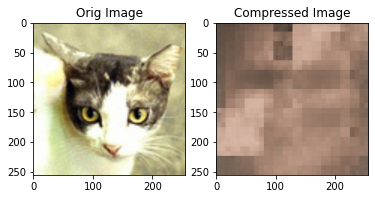

In [0]:
PIC = np.random.choice(500)
print(PIC)
plt.subplot(1,2,1)
plt.imshow(decoder_model.imgs[PIC])
plt.title('Orig Image')

plt.subplot(1,2,2)
plt.imshow(compressed[PIC])
plt.title('Compressed Image')

plt.show()

In [0]:
save_to_git('reduced_size_of_pulls')

Already up to date.
[master 574bf4c] reduced_size_of_pulls
 5 files changed, 236 insertions(+), 23 deletions(-)
 rewrite faces_capstone2/decoder.h5 (76%)
 rewrite faces_capstone2/faces_decoder.ipynb (91%)
 create mode 100644 faces_capstone2/test.csv
 create mode 100644 faces_capstone2/test.h5
 rewrite faces_capstone2/train_log.csv (96%)
Counting objects: 8, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (8/8), done.
Writing objects: 100% (8/8), 2.08 MiB | 1.53 MiB/s, done.
Total 8 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To github.com:rashmi-raviprasad/springboard.git
   7f8fb14..574bf4c  master -> master


In [0]:
os.chdir(REPOSITORY+'/faces_capstone2')
log = pd.read_csv(LOGS_FN)
log.head()

,Date,Run_Number,Num_Epochs_Tot,Train_Loss,Valid_Loss
0,2020-03-10 02:27:40.443648,0,0,NaN,NaN
1,2020-03-10 02:28:16.455108,1,5,0.031323,0.057537
2,2020-03-10 02:28:58.949584,2,10,0.019592,0.059774
3,2020-03-10 02:29:45.312118,3,15,0.015328,0.060629
4,2020-03-10 02:30:29.528276,4,20,0.013094,0.059538


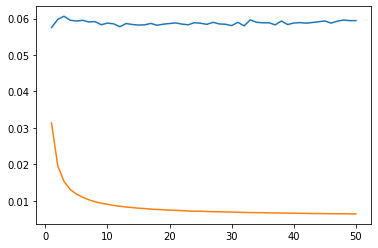

In [0]:
plt.plot(log[['Valid_Loss', 'Train_Loss']])
plt.show()